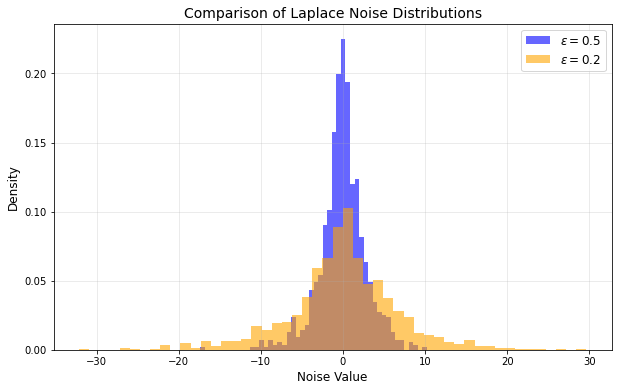

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate Laplace noise
def generate_laplace_noise(epsilon, sensitivity, size=1000):
    b = sensitivity / epsilon  # Scale parameter
    return np.random.laplace(0, b, size)

# Parameters
sensitivity = 1
size = 1000  # Number of samples

# Generate Laplace noise
laplace_noise_1 = generate_laplace_noise(epsilon=0.5, sensitivity=sensitivity, size=size)
laplace_noise_2 = generate_laplace_noise(epsilon=0.2, sensitivity=sensitivity, size=size)

# Plot the distributions
plt.figure(figsize=(10, 6))
plt.hist(laplace_noise_1, bins=50, alpha=0.6, label=r"$\epsilon=0.5$", color='blue', density=True)
plt.hist(laplace_noise_2, bins=50, alpha=0.6, label=r"$\epsilon=0.2$", color='orange', density=True)
plt.title("Comparison of Laplace Noise Distributions", fontsize=14)
plt.xlabel("Noise Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

真实 mean: 0.4995, 真实 var: 0.0831
===== 结果概览 =====
ε=0.10, Mean_MSE=0.002195, Var_MSE=0.000177
ε=0.30, Mean_MSE=0.000634, Var_MSE=0.000109
ε=0.50, Mean_MSE=0.002734, Var_MSE=0.000083
ε=0.70, Mean_MSE=0.001611, Var_MSE=0.000151
ε=1.00, Mean_MSE=0.000366, Var_MSE=0.000027
ε=2.00, Mean_MSE=0.000200, Var_MSE=0.000028


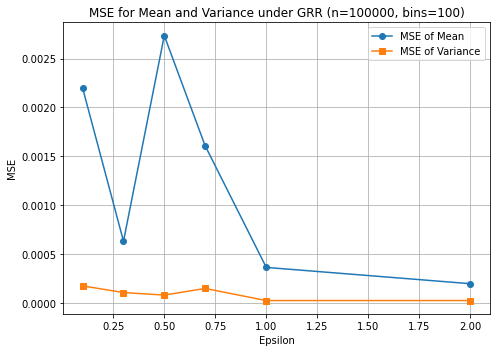

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def grr_client(value, epsilon=0.5, num_bins=100):
    """
    给定单个用户的真实数值 value ∈ [0,1]，将其映射到 [0,1] 区间上的 num_bins 段，
    使用 GRR (Generalized Random Response) 生成并返回扰动后的 bin index。
    """
    # 1. 找到所属 bin
    true_bin = int(value * num_bins)
    if true_bin == num_bins:
        true_bin = num_bins - 1

    # 2. 计算保真概率 p 和噪声概率 q
    k = num_bins
    exp_epsilon = np.exp(epsilon)  # e^ε
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    # 3. 根据 p/q 进行随机化上报
    rand_draw = np.random.rand()
    if rand_draw < p:
        reported_bin = true_bin
    else:
        # 从其余 k-1 中随机选一个
        other_bins = list(range(k))
        other_bins.remove(true_bin)
        reported_bin = np.random.choice(other_bins)

    return reported_bin

def grr_aggregator(reported_bins, epsilon=0.5, num_bins=100):
    """
    聚合方根据所有用户的扰动后 bin index 来估计最终的均值 (mean) 和方差 (variance)。
    """
    counts = np.zeros(num_bins, dtype=int)
    for b in reported_bins:
        counts[b] += 1

    n = len(reported_bins)
    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    # 1. 观测频率
    freq_obs = counts / float(n)
    # 2. 估计真实 bin 分布
    #    prob(bin = i) ≈ max(0, (freq_obs[i] - q) / (p - q))，并归一化
    estimated_prob = np.maximum(0, (freq_obs - q) / (p - q))
    if estimated_prob.sum() > 0:
        estimated_prob /= estimated_prob.sum()
    else:
        # 防止出现所有值都很小导致负数，简单兜底
        estimated_prob = np.ones(k) / k

    # 3. 根据 bin 中点估计 mean
    #    bin i ~ [i/k, (i+1)/k)，取 midpoint (i+0.5)/k
    bin_midpoints = np.array([(i + 0.5) / k for i in range(k)])
    estimated_mean = np.sum(estimated_prob * bin_midpoints)

    # 4. 根据 bin 中点估计 second moment E[X^2]，然后估计 variance = E[X^2] - (E[X])^2
    bin_midpoints_sq = bin_midpoints**2
    estimated_second_moment = np.sum(estimated_prob * bin_midpoints_sq)
    estimated_variance = estimated_second_moment - (estimated_mean**2)

    return estimated_mean, estimated_variance

def simulate_grr(num_users=10**5, epsilons=[0.1, 0.3, 0.5, 0.7, 1.0, 2.0], 
                 num_bins=100, num_runs=5, random_seed=42):
    """
    在给定用户数、不同 epsilon、分 bin 数以及重复次数下，
    模拟 GRR 并统计 mean/variance 的 MSE。
    - num_runs: 为了更稳定地估计误差，可多次重复试验
    """
    np.random.seed(random_seed)

    # 真实数据：假设 Uniform[0,1]
    true_values = np.random.rand(num_users)
    true_mean = np.mean(true_values)
    true_var = np.var(true_values)  # np.var 默认无偏吗？注意 numpy中 ddof=0 => 样本方差估计

    # 用于保存各 epsilon 下的 MSE(mean) / MSE(var)
    mse_mean_list = []
    mse_var_list = []

    for eps in epsilons:
        mean_errors = []
        var_errors = []

        for _ in range(num_runs):
            # 用户端执行GRR
            reported_bins = []
            for val in true_values:
                rb = grr_client(val, epsilon=eps, num_bins=num_bins)
                reported_bins.append(rb)

            # 聚合方估计 mean / var
            est_mean, est_var = grr_aggregator(reported_bins, epsilon=eps, num_bins=num_bins)
            
            # 计算误差
            mean_error = (est_mean - true_mean)**2
            var_error  = (est_var - true_var)**2
            mean_errors.append(mean_error)
            var_errors.append(var_error)

        # 在 num_runs 次试验后，取平均 MSE
        mse_mean = np.mean(mean_errors)
        mse_var  = np.mean(var_errors)

        mse_mean_list.append(mse_mean)
        mse_var_list.append(mse_var)

    return epsilons, mse_mean_list, mse_var_list, true_mean, true_var

def main():
    # 参数设置
    num_users = 10**5
    epsilons = [0.1, 0.3, 0.5, 0.7, 1.0, 2.0]
    num_bins = 100
    num_runs = 5

    # 进行模拟
    epsilons_res, mse_mean_res, mse_var_res, true_mean, true_var = simulate_grr(
        num_users=num_users,
        epsilons=epsilons,
        num_bins=num_bins,
        num_runs=num_runs,
        random_seed=42
    )

    print(f"真实 mean: {true_mean:.4f}, 真实 var: {true_var:.4f}")
    print("===== 结果概览 =====")
    for e, mm, mv in zip(epsilons_res, mse_mean_res, mse_var_res):
        print(f"ε={e:.2f}, Mean_MSE={mm:.6f}, Var_MSE={mv:.6f}")

    # 画图
    plt.figure(figsize=(7,5))
    plt.plot(epsilons_res, mse_mean_res, marker='o', label='MSE of Mean')
    plt.plot(epsilons_res, mse_var_res, marker='s', label='MSE of Variance')
    plt.xlabel('Epsilon')
    plt.ylabel('MSE')
    plt.title(f'MSE for Mean and Variance under GRR (n={num_users}, bins={num_bins})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

n=10000, LDP(MSE)=0.0010538066, Shuffle(MSE)=0.0000109654
n=20000, LDP(MSE)=0.0021041002, Shuffle(MSE)=0.0000024869
n=40000, LDP(MSE)=0.0009336495, Shuffle(MSE)=0.0000007048
n=60000, LDP(MSE)=0.0020835043, Shuffle(MSE)=0.0000004895
n=80000, LDP(MSE)=0.0011225596, Shuffle(MSE)=0.0000004553
n=100000, LDP(MSE)=0.0018067657, Shuffle(MSE)=0.0000000668


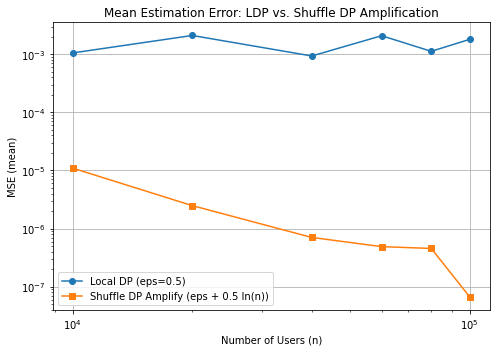

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def grr_client(value, epsilon=0.5, num_bins=100):
    """
    给定单个用户的真实数值 value ∈ [0,1]，将其映射到 [0,1] 区间上的 num_bins 段，
    使用 GRR 生成并返回扰动后的 bin index。
    """
    true_bin = int(value * num_bins)
    if true_bin == num_bins:  # 避免浮点导致索引越界
        true_bin = num_bins - 1

    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    rand_draw = np.random.rand()
    if rand_draw < p:
        reported_bin = true_bin
    else:
        other_bins = list(range(k))
        other_bins.remove(true_bin)
        reported_bin = np.random.choice(other_bins)

    return reported_bin

def grr_aggregator(reported_bins, epsilon=0.5, num_bins=100):
    """
    聚合方：根据所有用户的扰动后 bin index 来估计最终的均值。
    """
    counts = np.zeros(num_bins, dtype=int)
    for b in reported_bins:
        counts[b] += 1

    n = len(reported_bins)
    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    freq_obs = counts / float(n)
    est_prob = np.maximum(0, (freq_obs - q) / (p - q))
    s = est_prob.sum()
    if s > 0:
        est_prob /= s
    else:
        est_prob = np.ones(k) / k  # 兜底

    # bin 中点
    bin_midpoints = np.array([(i + 0.5) / k for i in range(k)])
    estimated_mean = np.sum(est_prob * bin_midpoints)

    return estimated_mean

def run_simulation(n=10**5, epsilon=0.5, shuffle_amplify=False, num_bins=100, num_runs=5, seed=42):
    """
    在给定用户数量 n、名义 epsilon、是否使用 shuffle 放大，以及重复次数下，
    模拟 GRR 并统计对 mean 的 MSE。
    - shuffle_amplify=True 时，使用 epsilon' = epsilon + 0.5*ln(n)
    - 返回 (mean_mse, true_mean)
    """
    np.random.seed(seed)
    true_values = np.random.rand(n)  # Uniform[0,1]
    true_mean = np.mean(true_values)

    # 如果是 shuffle DP，采用放大后的有效 epsilon'
    if shuffle_amplify:
        epsilon_eff = epsilon + 0.5 * np.log(n)
    else:
        epsilon_eff = epsilon

    mean_errors = []
    for _ in range(num_runs):
        # GRR 过程
        reported_bins = []
        for val in true_values:
            rb = grr_client(val, epsilon=epsilon_eff, num_bins=num_bins)
            reported_bins.append(rb)

        # 聚合估计
        est_mean = grr_aggregator(reported_bins, epsilon=epsilon_eff, num_bins=num_bins)
        # 误差
        mean_errors.append((est_mean - true_mean)**2)

    # 取多次试验平均 MSE
    mean_mse = np.mean(mean_errors)
    return mean_mse, true_mean

def main():
    eps = 0.5
    ns = [10**4, 2*10**4,  4*10**4, 6*10**4,  8*10**4, 10**5]  # 不同的用户数量
    num_bins = 100
    num_runs = 3  # 多次重复以稳定结果

    mse_ldp_list = []
    mse_shuffle_list = []

    # 模拟 LDP vs. Shuffle DP
    for n in ns:
        # LDP: 直接 epsilon = 0.5
        mse_ldp, tmean = run_simulation(n=n, epsilon=eps, shuffle_amplify=False,
                                        num_bins=num_bins, num_runs=num_runs)
        # Shuffle DP: epsilon' = eps + 0.5 ln(n)
        mse_shuffle, _ = run_simulation(n=n, epsilon=eps, shuffle_amplify=True,
                                        num_bins=num_bins, num_runs=num_runs)
        mse_ldp_list.append(mse_ldp)
        mse_shuffle_list.append(mse_shuffle)

        print(f"n={n}, LDP(MSE)={mse_ldp:.10f}, Shuffle(MSE)={mse_shuffle:.10f}")

    # 画图
    plt.figure(figsize=(7,5))
    plt.plot(ns, mse_ldp_list, marker='o', label='Local DP (eps=0.5)')
    plt.plot(ns, mse_shuffle_list, marker='s', label='Shuffle DP Amplify (eps + 0.5 ln(n))')
    plt.xscale('log')  # x 轴用 log 显示
    plt.yscale('log')  # 根据需要也可以用线性刻度
    plt.xlabel('Number of Users (n)')
    plt.ylabel('MSE (mean)')
    plt.title('Mean Estimation Error: LDP vs. Shuffle DP Amplification')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


[n=10000, 10% Malicious] LDP(MSE)=0.2062953909, Shuffle(MSE)=0.0064196612
[n=20000, 10% Malicious] LDP(MSE)=0.2347324104, Shuffle(MSE)=0.0053147487
[n=40000, 10% Malicious] LDP(MSE)=0.2444971647, Shuffle(MSE)=0.0042052047
[n=60000, 10% Malicious] LDP(MSE)=0.2451250176, Shuffle(MSE)=0.0038662474
[n=80000, 10% Malicious] LDP(MSE)=0.2451735115, Shuffle(MSE)=0.0036630457
[n=100000, 10% Malicious] LDP(MSE)=0.2455318943, Shuffle(MSE)=0.0034497228


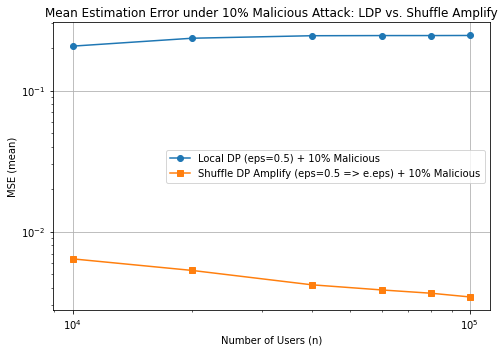

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def grr_client(value, epsilon=0.5, num_bins=100):
    """
    给定单个用户的真实数值 value ∈ [0,1]，将其映射到 [0,1] 区间上的 num_bins 段，
    使用 GRR 生成并返回扰动后的 bin index。
    """
    true_bin = int(value * num_bins)
    if true_bin == num_bins:
        true_bin = num_bins - 1

    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    rand_draw = np.random.rand()
    if rand_draw < p:
        reported_bin = true_bin
    else:
        other_bins = list(range(k))
        other_bins.remove(true_bin)
        reported_bin = np.random.choice(other_bins)

    return reported_bin

def grr_aggregator(reported_bins, epsilon=0.5, num_bins=100):
    """
    聚合方：根据所有用户的扰动后 bin index 来估计最终的均值 (mean)。
    """
    counts = np.zeros(num_bins, dtype=int)
    for b in reported_bins:
        counts[b] += 1

    n = len(reported_bins)
    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    freq_obs = counts / float(n)
    est_prob = np.maximum(0, (freq_obs - q) / (p - q))
    s = est_prob.sum()
    if s > 0:
        est_prob /= s
    else:
        est_prob = np.ones(k) / k  # 兜底

    # bin 中点
    bin_midpoints = np.array([(i + 0.5) / k for i in range(k)])
    estimated_mean = np.sum(est_prob * bin_midpoints)

    return estimated_mean

def run_simulation(n=10**5, epsilon=0.5, shuffle_amplify=False,
                   malicious_ratio=0.1, num_bins=100, num_runs=5, seed=42):
    """
    在给定用户数量 n、名义 epsilon、是否使用 shuffle 放大、恶意用户比例 malicious_ratio 下，
    模拟 GRR 并统计对 mean 的 MSE。
    恶意用户总是上报最大的 bin。
    - shuffle_amplify=True 时, epsilon_eff = epsilon + 0.5 ln(n)
    - 返回 (mean_mse, true_mean)
    """
    np.random.seed(seed)
    true_values = np.random.rand(n)  # Uniform[0,1]
    true_mean = np.mean(true_values)

    # 是否使用放大
    if shuffle_amplify:
        epsilon_eff = epsilon + 0.5 * np.log(n)
    else:
        epsilon_eff = epsilon

    # 计算恶意用户数量
    num_malicious = int(malicious_ratio * n)

    mean_errors = []
    for _ in range(num_runs):
        # 每次都重新生成用户，并打乱分配谁是恶意用户
        indices = np.arange(n)
        np.random.shuffle(indices)
        malicious_indices = set(indices[:num_malicious])
        # reported bins
        reported_bins = []

        for i in range(n):
            if i in malicious_indices:
                # 恶意用户：始终上报最大的 bin
                rb = num_bins - 1
            else:
                # 诚实用户：执行 GRR
                rb = grr_client(true_values[i], epsilon=epsilon_eff, num_bins=num_bins)
            reported_bins.append(rb)

        # 聚合估计
        est_mean = grr_aggregator(reported_bins, epsilon=epsilon_eff, num_bins=num_bins)
        mean_error = (est_mean - true_mean)**2
        mean_errors.append(mean_error)

    mean_mse = np.mean(mean_errors)
    return mean_mse, true_mean

def main():
    # 设定 epsilon=0.5
    eps = 0.5
    # 用户数量: [1e4, 1e5, 1e6]
    ns = [10**4, 2*10**4,  4*10**4, 6*10**4,  8*10**4, 10**5]
    # malicious ratio=10%
    malicious_ratio = 0.1
    num_bins = 100
    num_runs = 3

    mse_ldp_list = []
    mse_shuffle_list = []

    for n in ns:
        # LDP
        mse_ldp, tmean = run_simulation(n=n, epsilon=eps, shuffle_amplify=False,
                                        malicious_ratio=malicious_ratio,
                                        num_bins=num_bins, num_runs=num_runs, seed=42)
        # Shuffle DP
        mse_shuffle, _ = run_simulation(n=n, epsilon=eps, shuffle_amplify=True,
                                        malicious_ratio=malicious_ratio,
                                        num_bins=num_bins, num_runs=num_runs, seed=42)

        mse_ldp_list.append(mse_ldp)
        mse_shuffle_list.append(mse_shuffle)
        print(f"[n={n}, 10% Malicious] LDP(MSE)={mse_ldp:.10f}, Shuffle(MSE)={mse_shuffle:.10f}")

    # 画图
    plt.figure(figsize=(7,5))
    plt.plot(ns, mse_ldp_list, marker='o', label='Local DP (eps=0.5) + 10% Malicious')
    plt.plot(ns, mse_shuffle_list, marker='s', label='Shuffle DP Amplify (eps=0.5 => e.eps) + 10% Malicious')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Users (n)')
    plt.ylabel('MSE (mean)')
    plt.title('Mean Estimation Error under 10% Malicious Attack: LDP vs. Shuffle Amplify')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


[n=10000, 10% Malicious Input=1.0] LDP(MSE)=0.0015865105, Shuffle(MSE)=0.0023559659
[n=20000, 10% Malicious Input=1.0] LDP(MSE)=0.0011384025, Shuffle(MSE)=0.0024233629
[n=40000, 10% Malicious Input=1.0] LDP(MSE)=0.0016659945, Shuffle(MSE)=0.0024527950
[n=60000, 10% Malicious Input=1.0] LDP(MSE)=0.0007265123, Shuffle(MSE)=0.0024119494
[n=80000, 10% Malicious Input=1.0] LDP(MSE)=0.0002706147, Shuffle(MSE)=0.0024076677
[n=100000, 10% Malicious Input=1.0] LDP(MSE)=0.0001024942, Shuffle(MSE)=0.0025100707


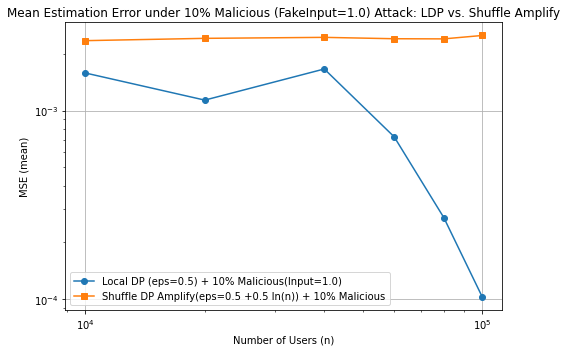

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def grr_client(value, epsilon=0.5, num_bins=100):
    """
    给定单个用户的真实数值 value ∈ [0,1]，将其映射到 [0,1] 区间上的 num_bins 段，
    使用 Generalized Random Response (GRR) 生成并返回扰动后的 bin index。
    """
    true_bin = int(value * num_bins)
    if true_bin == num_bins:  # 避免浮点边界情况
        true_bin = num_bins - 1

    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    rand_draw = np.random.rand()
    if rand_draw < p:
        reported_bin = true_bin
    else:
        other_bins = list(range(k))
        other_bins.remove(true_bin)
        reported_bin = np.random.choice(other_bins)

    return reported_bin

def grr_aggregator(reported_bins, epsilon=0.5, num_bins=100):
    """
    聚合方：根据所有用户的扰动后 bin index 来估计最终的均值 (mean)。
    """
    counts = np.zeros(num_bins, dtype=int)
    for b in reported_bins:
        counts[b] += 1

    n = len(reported_bins)
    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    # 统计频率
    freq_obs = counts / float(n)
    # 逆推真实 bin 分布 prob[i]
    # max(0, (freq_obs[i] - q)/(p-q)) 并做归一化
    est_prob = np.maximum(0, (freq_obs - q) / (p - q))
    s = est_prob.sum()
    if s > 0:
        est_prob /= s
    else:
        est_prob = np.ones(k) / k  # 兜底：防止全部小于 q

    # bin 的中点
    bin_midpoints = np.array([(i + 0.5) / k for i in range(k)])
    estimated_mean = np.sum(est_prob * bin_midpoints)

    return estimated_mean

def run_simulation(n=10**5, epsilon=0.5, shuffle_amplify=False,
                   malicious_ratio=0.1, num_bins=100, num_runs=5, seed=42):
    """
    在给定用户数量 n、名义 epsilon、是否使用 shuffle 放大、恶意用户比例 malicious_ratio 下，
    模拟 GRR 并统计对 mean 的 MSE (与真实 mean 的 (估计-真实)^2)。
    与以往不同：恶意用户将自己的输入设为 value=1.0 后再走 GRR。
    - shuffle_amplify=True 时, epsilon_eff = epsilon + 0.5*ln(n)
    - 返回 (mean_mse, true_mean)
    """
    np.random.seed(seed)
    # 1) 生成真实数据：Uniform[0,1]
    true_values = np.random.rand(n)
    true_mean = np.mean(true_values)

    # 2) 选取恶意用户数量
    num_malicious = int(malicious_ratio * n)

    # 3) 是否放大
    if shuffle_amplify:
        epsilon_eff = epsilon + 0.5 * np.log(n)
    else:
        epsilon_eff = epsilon

    # 记录多次试验的误差
    mean_errors = []

    for _ in range(num_runs):
        # 打乱用户索引，前 num_malicious 个视为恶意
        indices = np.arange(n)
        np.random.shuffle(indices)
        malicious_indices = set(indices[:num_malicious])

        # 上报 bins
        reported_bins = []
        for i in range(n):
            if i in malicious_indices:
                # 恶意用户：将输入设为 1.0 再执行 GRR
                fake_value = 1.0
                rb = grr_client(fake_value, epsilon=epsilon_eff, num_bins=num_bins)
            else:
                # 诚实用户：按真实值执行 GRR
                rb = grr_client(true_values[i], epsilon=epsilon_eff, num_bins=num_bins)
            reported_bins.append(rb)

        # 聚合方估计 mean
        est_mean = grr_aggregator(reported_bins, epsilon=epsilon_eff, num_bins=num_bins)
        mean_error = (est_mean - true_mean)**2
        mean_errors.append(mean_error)

    # 返回平均 MSE
    mean_mse = np.mean(mean_errors)
    return mean_mse, true_mean

def main():
    # 设定 epsilon=0.5
    eps = 0.5
    # 用户规模
    ns = [10**4, 2*10**4,  4*10**4, 6*10**4,  8*10**4, 10**5]
    malicious_ratio = 0.1  # 10% 恶意用户
    num_bins = 100
    num_runs = 3  # 每个场景重复若干次，取平均

    mse_ldp_list = []
    mse_shuffle_list = []

    for n in ns:
        # Local DP 场景
        mse_ldp, tmean = run_simulation(
            n=n,
            epsilon=eps,
            shuffle_amplify=False,
            malicious_ratio=malicious_ratio,
            num_bins=num_bins,
            num_runs=num_runs,
            seed=42
        )
        # Shuffle DP 场景 (amplify)
        mse_shuffle, _ = run_simulation(
            n=n,
            epsilon=eps,
            shuffle_amplify=True,
            malicious_ratio=malicious_ratio,
            num_bins=num_bins,
            num_runs=num_runs,
            seed=42
        )
        mse_ldp_list.append(mse_ldp)
        mse_shuffle_list.append(mse_shuffle)

        print(f"[n={n}, 10% Malicious Input=1.0] LDP(MSE)={mse_ldp:.10f}, Shuffle(MSE)={mse_shuffle:.10f}")

    # 画图
    plt.figure(figsize=(7,5))
    plt.plot(ns, mse_ldp_list, marker='o', label='Local DP (eps=0.5) + 10% Malicious(Input=1.0)')
    plt.plot(ns, mse_shuffle_list, marker='s', label='Shuffle DP Amplify(eps=0.5 +0.5 ln(n)) + 10% Malicious')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Users (n)')
    plt.ylabel('MSE (mean)')
    plt.title('Mean Estimation Error under 10% Malicious (FakeInput=1.0) Attack: LDP vs. Shuffle Amplify')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


=== n=10000 ===
  LDP  MSEs: [0.0005668789643785648, 0.00039295311779436034, 0.00019376565378856656, 0.0017271999975113626, 0.002266005336123994, 6.994928947304557e-05, 0.0002952188311577575, 8.359660974845091e-05, 0.0023354473081030605, 0.00031155061680387757]
  SHUF MSEs: [0.0025100554328525695, 0.002923556662380484, 0.0020478294723856004, 0.0024714799342334414, 0.0020881981913447394, 0.002367525896244804, 0.002311846673371127, 0.002847023047791967, 0.0024646549743072986, 0.002132452528811921]
=== n=20000 ===
  LDP  MSEs: [1.0000062625814122e-05, 0.003055071467755245, 0.003367705285228801, 0.00014019268939969494, 4.9115486474976133e-05, 0.0009693525362119859, 0.0025052096948555537, 6.233619876931989e-05, 0.0006730590924007805, 0.004367363286951256]
  SHUF MSEs: [0.0023831328131332066, 0.0024193367871143175, 0.0019372035065893412, 0.002622871792838129, 0.002646766868860517, 0.002954923243971881, 0.0025835740735847008, 0.002406857141906027, 0.0022731344287080643, 0.002320269902450838]


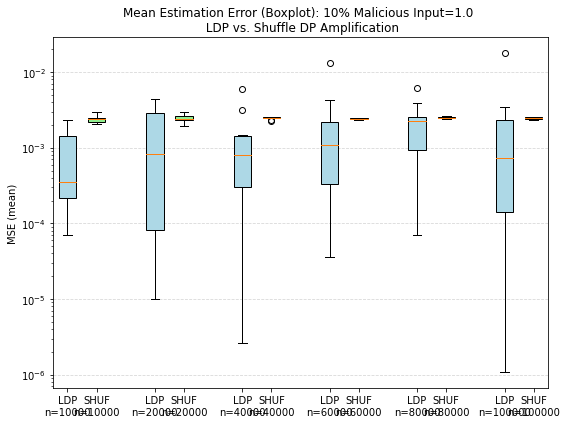

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def grr_client(value, epsilon=0.5, num_bins=100):
    """
    给定单个用户的真实数值 value ∈ [0,1]，将其映射到 [0,1] 区间上的 num_bins 段，
    使用 Generalized Random Response (GRR) 生成并返回扰动后的 bin index。
    """
    true_bin = int(value * num_bins)
    if true_bin == num_bins:
        true_bin = num_bins - 1

    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    rand_draw = np.random.rand()
    if rand_draw < p:
        reported_bin = true_bin
    else:
        other_bins = list(range(k))
        other_bins.remove(true_bin)
        reported_bin = np.random.choice(other_bins)

    return reported_bin

def grr_aggregator(reported_bins, epsilon=0.5, num_bins=100):
    """
    聚合方：根据所有用户的扰动后 bin index 来估计最终的均值 (mean)。
    """
    counts = np.zeros(num_bins, dtype=int)
    for b in reported_bins:
        counts[b] += 1

    n = len(reported_bins)
    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    freq_obs = counts / float(n)
    est_prob = np.maximum(0, (freq_obs - q) / (p - q))
    s = est_prob.sum()
    if s > 0:
        est_prob /= s
    else:
        est_prob = np.ones(k) / k  # 兜底

    bin_midpoints = np.array([(i + 0.5) / k for i in range(k)])
    estimated_mean = np.sum(est_prob * bin_midpoints)

    return estimated_mean

def run_one_experiment(n, epsilon, shuffle_amplify, malicious_ratio, num_bins, seed=None):
    """
    进行一次实验（单次），返回该次实验下的 (true_mean, estimated_mean, MSE)。
    攻击场景：10% 用户伪造输入=1.0，再执行正常GRR，其余诚实用户 Uniform[0,1].
    """
    if seed is not None:
        np.random.seed(seed)

    # 1) 生成真实数据
    true_values = np.random.rand(n)  # honest majority
    true_mean = np.mean(true_values)

    # 2) 选出恶意用户 (10%)
    num_malicious = int(malicious_ratio * n)
    indices = np.arange(n)
    np.random.shuffle(indices)
    malicious_indices = set(indices[:num_malicious])

    # 3) 如果是shuffle DP, 放大 epsilon
    if shuffle_amplify:
        epsilon_eff = epsilon + 0.5 * np.log(n)
    else:
        epsilon_eff = epsilon

    # 4) 模拟上报
    reported_bins = []
    for i in range(n):
        if i in malicious_indices:
            # 恶意用户：先把输入设为 1.0，再执行 GRR
            val = 1.0
        else:
            # 诚实用户
            val = true_values[i]

        rb = grr_client(val, epsilon=epsilon_eff, num_bins=num_bins)
        reported_bins.append(rb)

    # 5) 聚合
    est_mean = grr_aggregator(reported_bins, epsilon=epsilon_eff, num_bins=num_bins)
    mse = (est_mean - true_mean)**2

    return true_mean, est_mean, mse

def run_experiments(n, epsilon, shuffle_amplify, malicious_ratio=0.1,
                    num_bins=100, num_runs=10, seed=42):
    """
    重复执行多次实验，返回所有 MSE 列表 (length=num_runs).
    """
    mses = []
    rng = np.random.RandomState(seed)
    for run_id in range(num_runs):
        # 为每次实验生成不同 seed
        run_seed = rng.randint(10**9)
        _, _, mse = run_one_experiment(n=n, epsilon=epsilon, shuffle_amplify=shuffle_amplify,
                                       malicious_ratio=malicious_ratio,
                                       num_bins=num_bins, seed=run_seed)
        mses.append(mse)
    return mses

def main():
    # 固定 epsilon=0.5, 恶意用户 10%
    epsilon = 0.5
    malicious_ratio = 0.1
    ns = [10**4, 2*10**4,  4*10**4, 6*10**4,  8*10**4, 10**5]
    num_bins = 100
    num_runs = 10  # 每个场景重复 10 次实验

    # 用于存储不同 n 下 LDP 和 Shuffle DP 的误差分布
    all_ldp_mse = []
    all_shuffle_mse = []

    for n in ns:
        # LDP
        ldp_mses = run_experiments(
            n=n,
            epsilon=epsilon,
            shuffle_amplify=False,
            malicious_ratio=malicious_ratio,
            num_bins=num_bins,
            num_runs=num_runs,
            seed=42
        )
        # Shuffle DP
        shuffle_mses = run_experiments(
            n=n,
            epsilon=epsilon,
            shuffle_amplify=True,
            malicious_ratio=malicious_ratio,
            num_bins=num_bins,
            num_runs=num_runs,
            seed=666  # 换个随机种子，不与LDP实验冲突
        )

        all_ldp_mse.append(ldp_mses)
        all_shuffle_mse.append(shuffle_mses)

        print(f"=== n={n} ===")
        print(f"  LDP  MSEs: {ldp_mses}")
        print(f"  SHUF MSEs: {shuffle_mses}")

    # 绘制箱线图
    # 我们在 x 轴上分三组 (n=1e4, 1e5, 1e6)，每组里放2个箱线图 (LDP / Shuffle)
    plt.figure(figsize=(8,6))
    positions = []
    data_for_box = []
    x_labels = []
    group_gap = 3  # 每组在x方向间隔

    for i, n in enumerate(ns):
        # group i: LDP/Shuffle
        # 两个箱线图的x位置
        base_x = i * group_gap
        ldp_x = base_x + 1
        shuf_x = base_x + 2

        positions.append(ldp_x)
        positions.append(shuf_x)
        data_for_box.append(all_ldp_mse[i])
        data_for_box.append(all_shuffle_mse[i])

        x_labels.append(f"LDP\nn={n}")
        x_labels.append(f"SHUF\nn={n}")

    # 绘制箱线图
    bp = plt.boxplot(data_for_box, positions=positions, widths=0.6, patch_artist=True,
                     showfliers=True,  # 是否显示异常值
                     labels=x_labels)

    # 美化箱线图颜色等
    # 假设偶数为 shuffle, 奇数为 ldp
    # 也可根据需求给 LDP 和 Shuffle 分别上色
    for i, box in enumerate(bp['boxes']):
        if i % 2 == 0:
            # 偶数: LDP
            box.set(facecolor='lightblue')
        else:
            # 奇数: Shuffle
            box.set(facecolor='lightgreen')

    plt.yscale('log')
    plt.ylabel("MSE (mean)")
    plt.title("Mean Estimation Error (Boxplot): 10% Malicious Input=1.0 \n LDP vs. Shuffle DP Amplification")
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


=== n=10000 ===
  LDP   MSEs: [0.0005668789643785648, 0.00039295311779436034, 0.00019376565378856656, 0.0017271999975113626, 0.002266005336123994, 6.994928947304557e-05, 0.0002952188311577575, 8.359660974845091e-05, 0.0023354473081030605, 0.00031155061680387757]
  Shuffle MSEs: [0.002013178551984882, 0.0023613415605252485, 0.0023338728232882113, 0.0024743281831332573, 0.0020552745466222086, 0.0018045317718790828, 0.002416564248444243, 0.002342537494084252, 0.0028977147557857435, 0.002613890969535603]
=== n=20000 ===
  LDP   MSEs: [1.0000062625814122e-05, 0.003055071467755245, 0.003367705285228801, 0.00014019268939969494, 4.9115486474976133e-05, 0.0009693525362119859, 0.0025052096948555537, 6.233619876931989e-05, 0.0006730590924007805, 0.004367363286951256]
  Shuffle MSEs: [0.0024062574543244875, 0.0030006429037065644, 0.00294173547215146, 0.002654863500763617, 0.0028066561620054193, 0.0027386875795408308, 0.002332155270457189, 0.0025167345147590085, 0.0024275618728139543, 0.00221384166

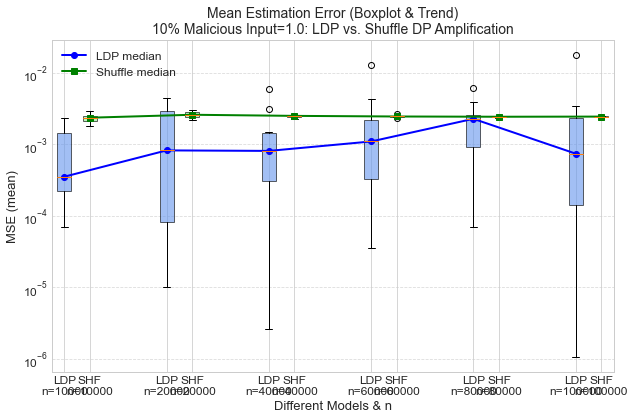

In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def grr_client(value, epsilon=0.5, num_bins=100):
    true_bin = int(value * num_bins)
    if true_bin == num_bins:
        true_bin = num_bins - 1

    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    rand_draw = np.random.rand()
    if rand_draw < p:
        reported_bin = true_bin
    else:
        other_bins = list(range(k))
        other_bins.remove(true_bin)
        reported_bin = np.random.choice(other_bins)
    return reported_bin

def grr_aggregator(reported_bins, epsilon=0.5, num_bins=100):
    counts = np.zeros(num_bins, dtype=int)
    for b in reported_bins:
        counts[b] += 1

    n = len(reported_bins)
    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    freq_obs = counts / float(n)
    est_prob = np.maximum(0, (freq_obs - q) / (p - q))
    s = est_prob.sum()
    if s > 0:
        est_prob /= s
    else:
        est_prob = np.ones(k) / k

    bin_midpoints = np.array([(i + 0.5) / k for i in range(k)])
    estimated_mean = np.sum(est_prob * bin_midpoints)

    return estimated_mean

def run_one_experiment(n, epsilon, shuffle_amplify, malicious_ratio, num_bins, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # 真实值
    true_values = np.random.rand(n)
    true_mean = np.mean(true_values)

    # 恶意用户：10% 将输入固定为1.0
    num_malicious = int(malicious_ratio * n)
    indices = np.arange(n)
    np.random.shuffle(indices)
    malicious_indices = set(indices[:num_malicious])

    if shuffle_amplify:
        epsilon_eff = epsilon + 0.5 * np.log(n)
    else:
        epsilon_eff = epsilon

    reported_bins = []
    for i in range(n):
        if i in malicious_indices:
            val = 1.0
        else:
            val = true_values[i]
        rb = grr_client(val, epsilon=epsilon_eff, num_bins=num_bins)
        reported_bins.append(rb)

    est_mean = grr_aggregator(reported_bins, epsilon=epsilon_eff, num_bins=num_bins)
    mse = (est_mean - true_mean)**2
    return true_mean, est_mean, mse

def run_experiments(n, epsilon, shuffle_amplify, malicious_ratio=0.1,
                    num_bins=100, num_runs=10, seed=42):
    mses = []
    rng = np.random.RandomState(seed)
    for _ in range(num_runs):
        run_seed = rng.randint(10**9)
        _, _, mse = run_one_experiment(
            n=n,
            epsilon=epsilon,
            shuffle_amplify=shuffle_amplify,
            malicious_ratio=malicious_ratio,
            num_bins=num_bins,
            seed=run_seed
        )
        mses.append(mse)
    return mses

def main():
    # 选用一个看起来较干净的绘图风格
    plt.style.use('seaborn-whitegrid')
    # 或可使用 plt.rcParams 调整更多细节
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['axes.labelsize'] = 13
    matplotlib.rcParams['axes.titlesize'] = 14
    matplotlib.rcParams['legend.fontsize'] = 12
    matplotlib.rcParams['lines.linewidth'] = 2

    epsilon = 0.5
    malicious_ratio = 0.1
    ns = [10**4, 2*10**4,  4*10**4, 6*10**4,  8*10**4, 10**5]
    num_bins = 100
    num_runs = 10

    # 存储: all_ldp_mse[i] => n=ns[i], LDP 模型下的10次MSE; all_shuffle_mse 同理
    all_ldp_mse = []
    all_shuffle_mse = []

    for i, n in enumerate(ns):
        ldp_mses = run_experiments(
            n=n, epsilon=epsilon,
            shuffle_amplify=False,
            malicious_ratio=malicious_ratio,
            num_bins=num_bins, num_runs=num_runs, seed=42
        )
        shuffle_mses = run_experiments(
            n=n, epsilon=epsilon,
            shuffle_amplify=True,
            malicious_ratio=malicious_ratio,
            num_bins=num_bins, num_runs=num_runs, seed=777
        )
        all_ldp_mse.append(ldp_mses)
        all_shuffle_mse.append(shuffle_mses)

        print(f"=== n={n} ===")
        print(f"  LDP   MSEs: {ldp_mses}")
        print(f"  Shuffle MSEs: {shuffle_mses}")

    # 开始绘图: 箱线图 + 折线
    plt.figure(figsize=(9,6))

    # x 轴上的分组位置
    group_gap = 4
    positions = []
    data_for_box = []
    x_labels = []
    # 记录给折线用的 x坐标、中位数
    ldp_x = []
    ldp_median = []
    shuffle_x = []
    shuffle_median = []

    for i, n in enumerate(ns):
        base_x = i * group_gap
        # LDP 在 base_x+1, Shuffle 在 base_x+2
        ldp_xpos = base_x + 1
        shf_xpos = base_x + 2

        ldp_x.append(ldp_xpos)
        shuffle_x.append(shf_xpos)

        # 收集箱线图数据
        data_for_box.append(all_ldp_mse[i])     # LDP
        data_for_box.append(all_shuffle_mse[i]) # Shuffle
        positions.append(ldp_xpos)
        positions.append(shf_xpos)

        # x 轴标签
        x_labels.append(f"LDP\nn={n}")
        x_labels.append(f"SHF\nn={n}")

        # 计算中位数
        ldp_median_val = np.median(all_ldp_mse[i])
        shf_median_val = np.median(all_shuffle_mse[i])
        ldp_median.append(ldp_median_val)
        shuffle_median.append(shf_median_val)

    # 绘制箱线图
    bp = plt.boxplot(
        data_for_box,
        positions=positions,
        widths=0.55,
        patch_artist=True,
        showfliers=True,  # 是否显示异常值
        labels=x_labels
    )

    # 为 LDP / Shuffle 设置不同填充色，交替出现
    for j, box in enumerate(bp['boxes']):
        if j % 2 == 0:
            box.set(facecolor='cornflowerblue', alpha=0.6)  # LDP
        else:
            box.set(facecolor='lightgreen', alpha=0.6)      # Shuffle

    # 在箱线图上叠加折线图，连中位数
    plt.plot(ldp_x, ldp_median, marker='o', color='blue', label='LDP median', linestyle='-')
    plt.plot(shuffle_x, shuffle_median, marker='s', color='green', label='Shuffle median', linestyle='-')

    # axes 设置
    plt.yscale('log')
    plt.xlabel('Different Models & n')
    plt.ylabel('MSE (mean)')
    plt.title("Mean Estimation Error (Boxplot & Trend)\n10% Malicious Input=1.0: LDP vs. Shuffle DP Amplification")
    plt.legend(loc='best')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


=== n=10000 ===
  LDP   MSEs: [0.0005668789643785648, 0.00039295311779436034, 0.00019376565378856656, 0.0017271999975113626, 0.002266005336123994, 6.994928947304557e-05, 0.0002952188311577575, 8.359660974845091e-05, 0.0023354473081030605, 0.00031155061680387757]
  Shuffle MSEs: [0.002013178551984882, 0.0023613415605252485, 0.0023338728232882113, 0.0024743281831332573, 0.0020552745466222086, 0.0018045317718790828, 0.002416564248444243, 0.002342537494084252, 0.0028977147557857435, 0.002613890969535603]
=== n=20000 ===
  LDP   MSEs: [1.0000062625814122e-05, 0.003055071467755245, 0.003367705285228801, 0.00014019268939969494, 4.9115486474976133e-05, 0.0009693525362119859, 0.0025052096948555537, 6.233619876931989e-05, 0.0006730590924007805, 0.004367363286951256]
  Shuffle MSEs: [0.0024062574543244875, 0.0030006429037065644, 0.00294173547215146, 0.002654863500763617, 0.0028066561620054193, 0.0027386875795408308, 0.002332155270457189, 0.0025167345147590085, 0.0024275618728139543, 0.00221384166

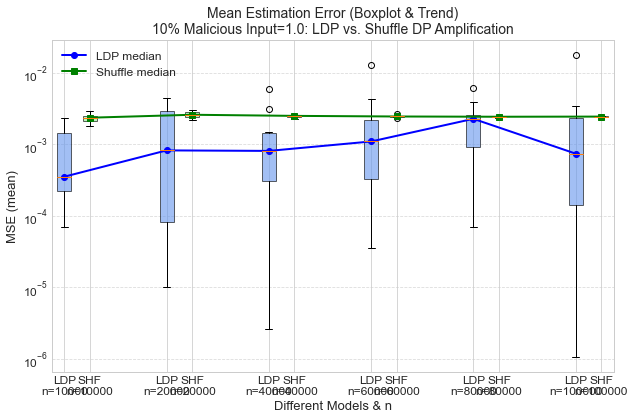

In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def grr_client(value, epsilon=0.5, num_bins=100):
    true_bin = int(value * num_bins)
    if true_bin == num_bins:
        true_bin = num_bins - 1

    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    rand_draw = np.random.rand()
    if rand_draw < p:
        reported_bin = true_bin
    else:
        other_bins = list(range(k))
        other_bins.remove(true_bin)
        reported_bin = np.random.choice(other_bins)
    return reported_bin

def grr_aggregator(reported_bins, epsilon=0.5, num_bins=100):
    counts = np.zeros(num_bins, dtype=int)
    for b in reported_bins:
        counts[b] += 1

    n = len(reported_bins)
    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    freq_obs = counts / float(n)
    est_prob = np.maximum(0, (freq_obs - q) / (p - q))
    s = est_prob.sum()
    if s > 0:
        est_prob /= s
    else:
        est_prob = np.ones(k) / k

    bin_midpoints = np.array([(i + 0.5) / k for i in range(k)])
    estimated_mean = np.sum(est_prob * bin_midpoints)

    return estimated_mean

def run_one_experiment(n, epsilon, shuffle_amplify, malicious_ratio, num_bins, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # 真实值
    true_values = np.random.rand(n)
    true_mean = np.mean(true_values)

    # 恶意用户：10% 将输入固定为1.0
    num_malicious = int(malicious_ratio * n)
    indices = np.arange(n)
    np.random.shuffle(indices)
    malicious_indices = set(indices[:num_malicious])

    if shuffle_amplify:
        epsilon_eff = epsilon + 0.5 * np.log(n)
    else:
        epsilon_eff = epsilon

    reported_bins = []
    for i in range(n):
        if i in malicious_indices:
            val = 1.0
        else:
            val = true_values[i]
        rb = grr_client(val, epsilon=epsilon_eff, num_bins=num_bins)
        reported_bins.append(rb)

    est_mean = grr_aggregator(reported_bins, epsilon=epsilon_eff, num_bins=num_bins)
    mse = (est_mean - true_mean)**2
    return true_mean, est_mean, mse

def run_experiments(n, epsilon, shuffle_amplify, malicious_ratio=0.1,
                    num_bins=100, num_runs=10, seed=42):
    mses = []
    rng = np.random.RandomState(seed)
    for _ in range(num_runs):
        run_seed = rng.randint(10**9)
        _, _, mse = run_one_experiment(
            n=n,
            epsilon=epsilon,
            shuffle_amplify=shuffle_amplify,
            malicious_ratio=malicious_ratio,
            num_bins=num_bins,
            seed=run_seed
        )
        mses.append(mse)
    return mses

def main():
    # 选用一个看起来较干净的绘图风格
    plt.style.use('seaborn-whitegrid')
    # 或可使用 plt.rcParams 调整更多细节
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['axes.labelsize'] = 13
    matplotlib.rcParams['axes.titlesize'] = 14
    matplotlib.rcParams['legend.fontsize'] = 12
    matplotlib.rcParams['lines.linewidth'] = 2

    epsilon = 0.5
    malicious_ratio = 0.1
    ns = [10**4, 2*10**4,  4*10**4, 6*10**4,  8*10**4, 10**5]
    num_bins = 100
    num_runs = 10

    # 存储: all_ldp_mse[i] => n=ns[i], LDP 模型下的10次MSE; all_shuffle_mse 同理
    all_ldp_mse = []
    all_shuffle_mse = []

    for i, n in enumerate(ns):
        ldp_mses = run_experiments(
            n=n, epsilon=epsilon,
            shuffle_amplify=False,
            malicious_ratio=malicious_ratio,
            num_bins=num_bins, num_runs=num_runs, seed=42
        )
        shuffle_mses = run_experiments(
            n=n, epsilon=epsilon,
            shuffle_amplify=True,
            malicious_ratio=malicious_ratio,
            num_bins=num_bins, num_runs=num_runs, seed=777
        )
        all_ldp_mse.append(ldp_mses)
        all_shuffle_mse.append(shuffle_mses)

        print(f"=== n={n} ===")
        print(f"  LDP   MSEs: {ldp_mses}")
        print(f"  Shuffle MSEs: {shuffle_mses}")

    # 开始绘图: 箱线图 + 折线
    plt.figure(figsize=(9,6))

    # x 轴上的分组位置
    group_gap = 4
    positions = []
    data_for_box = []
    x_labels = []
    # 记录给折线用的 x坐标、中位数
    ldp_x = []
    ldp_median = []
    shuffle_x = []
    shuffle_median = []

    for i, n in enumerate(ns):
        base_x = i * group_gap
        # LDP 在 base_x+1, Shuffle 在 base_x+2
        ldp_xpos = base_x + 1
        shf_xpos = base_x + 2

        ldp_x.append(ldp_xpos)
        shuffle_x.append(shf_xpos)

        # 收集箱线图数据
        data_for_box.append(all_ldp_mse[i])     # LDP
        data_for_box.append(all_shuffle_mse[i]) # Shuffle
        positions.append(ldp_xpos)
        positions.append(shf_xpos)

        # x 轴标签
        x_labels.append(f"LDP\nn={n}")
        x_labels.append(f"SHF\nn={n}")

        # 计算中位数
        ldp_median_val = np.median(all_ldp_mse[i])
        shf_median_val = np.median(all_shuffle_mse[i])
        ldp_median.append(ldp_median_val)
        shuffle_median.append(shf_median_val)

    # 绘制箱线图
    bp = plt.boxplot(
        data_for_box,
        positions=positions,
        widths=0.55,
        patch_artist=True,
        showfliers=True,  # 是否显示异常值
        labels=x_labels
    )

    # 为 LDP / Shuffle 设置不同填充色，交替出现
    for j, box in enumerate(bp['boxes']):
        if j % 2 == 0:
            box.set(facecolor='cornflowerblue', alpha=0.6)  # LDP
        else:
            box.set(facecolor='lightgreen', alpha=0.6)      # Shuffle

    # 在箱线图上叠加折线图，连中位数
    plt.plot(ldp_x, ldp_median, marker='o', color='blue', label='LDP median', linestyle='-')
    plt.plot(shuffle_x, shuffle_median, marker='s', color='green', label='Shuffle median', linestyle='-')

    # axes 设置
    plt.yscale('log')
    plt.xlabel('Different Models & n')
    plt.ylabel('MSE (mean)')
    plt.title("Mean Estimation Error (Boxplot & Trend)\n10% Malicious Input=1.0: LDP vs. Shuffle DP Amplification")
    plt.legend(loc='best')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


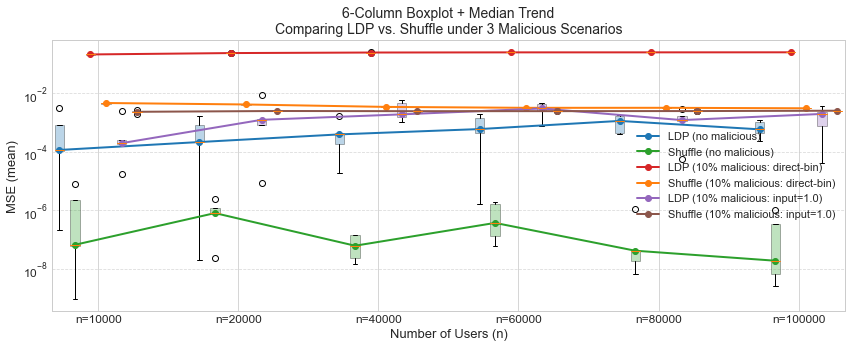

In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

############################
# 1. GRR 逻辑与聚合函数  #
############################

def grr_client(value, epsilon=0.5, num_bins=100):
    """ 
    给定单个用户的真实数值 value ∈ [0,1]，
    将其映射到 num_bins 段，使用 GRR 输出扰动后的 bin 索引。
    """
    true_bin = int(value * num_bins)
    if true_bin >= num_bins:
        true_bin = num_bins - 1

    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    rand_draw = np.random.rand()
    if rand_draw < p:
        reported_bin = true_bin
    else:
        other_bins = list(range(k))
        other_bins.remove(true_bin)
        reported_bin = np.random.choice(other_bins)
    return reported_bin

def grr_aggregator(reported_bins, epsilon=0.5, num_bins=100):
    """
    聚合方：根据所有用户上报的 bin 索引 counts，估计最终的均值 (mean)。
    """
    counts = np.zeros(num_bins, dtype=int)
    for b in reported_bins:
        counts[b] += 1

    n = len(reported_bins)
    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    freq_obs = counts / float(n)
    est_prob = np.maximum(0, (freq_obs - q) / (p - q))
    s = est_prob.sum()
    if s > 0:
        est_prob /= s
    else:
        est_prob = np.ones(k) / k  # 兜底：若数值不稳导致

    bin_midpoints = [(i + 0.5) / k for i in range(k)]
    estimated_mean = np.sum(est_prob * bin_midpoints)
    return estimated_mean

############################
# 2. 单次实验：区分攻击模式 #
############################

def run_one_experiment(
    n, epsilon, shuffle_amplify=False,
    malicious_mode=0, malicious_ratio=0.1,
    num_bins=100, seed=None
):
    """
    单次实验:
      - n: 用户总数
      - epsilon: 名义隐私参数
      - shuffle_amplify=True => epsilon' = epsilon + 0.5 ln(n) (Shuffle DP)
      - malicious_mode:
          0 => 无恶意用户
          1 => 恶意用户可直接提交最大 bin
          2 => 恶意用户只能将输入=1.0 后再执行GRR
      - malicious_ratio=0.1 => 10% 恶意
    返回 (true_mean, est_mean, mse).
    """
    if seed is not None:
        np.random.seed(seed)

    # 生成真实数据
    true_values = np.random.rand(n)
    true_mean = np.mean(true_values)

    # Shuffle DP 放大
    if shuffle_amplify:
        epsilon_eff = epsilon + 0.5 * np.log(n)
    else:
        epsilon_eff = epsilon

    # 选择恶意用户
    if malicious_mode == 0:
        malicious_indices = set()
    else:
        num_mal = int(malicious_ratio * n)
        indices = np.arange(n)
        np.random.shuffle(indices)
        malicious_indices = set(indices[:num_mal])

    reported_bins = []
    for i in range(n):
        if i in malicious_indices:
            if malicious_mode == 1:
                # 直接提交最大 bin
                rb = num_bins - 1
            elif malicious_mode == 2:
                # 先将输入=1.0，再执行GRR
                rb = grr_client(1.0, epsilon=epsilon_eff, num_bins=num_bins)
            else:
                rb = grr_client(true_values[i], epsilon=epsilon_eff, num_bins=num_bins)
        else:
            # 诚实用户
            rb = grr_client(true_values[i], epsilon=epsilon_eff, num_bins=num_bins)
        reported_bins.append(rb)

    est_mean = grr_aggregator(reported_bins, epsilon=epsilon_eff, num_bins=num_bins)
    mse = (est_mean - true_mean)**2
    return true_mean, est_mean, mse

############################
# 3. 多次实验：每组参数 -> MSE分布 #
############################

def run_experiments_for_mode(
    n_values, epsilon, malicious_mode, shuffle_amplify,
    malicious_ratio=0.1, num_bins=100, num_runs=5, seed=42
):
    """
    针对特定恶意模式 malicious_mode、是否 shuffle_amplify
    在不同 n_values 下重复实验 num_runs 次，返回 MSE列表 (二维：len(n_values) × num_runs)
    """
    rng = np.random.RandomState(seed)
    all_mses = []
    for n in n_values:
        run_mses = []
        for _ in range(num_runs):
            run_seed = rng.randint(1e9)
            _, _, mse = run_one_experiment(
                n=n, epsilon=epsilon, shuffle_amplify=shuffle_amplify,
                malicious_mode=malicious_mode, malicious_ratio=malicious_ratio,
                num_bins=num_bins, seed=run_seed
            )
            run_mses.append(mse)
        all_mses.append(run_mses)
    return all_mses  # len(n_values) × num_runs

############################
# 4. 主流程：画箱线图 + 中位数折线 #
############################

def main():
    plt.style.use('seaborn-whitegrid')
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['axes.labelsize'] = 13
    matplotlib.rcParams['axes.titlesize'] = 14
    matplotlib.rcParams['legend.fontsize'] = 11
    matplotlib.rcParams['lines.linewidth'] = 2

    # 配置
    epsilon = 1
    malicious_ratio = 0.1
    n_values = [10**4, 2*10**4,  4*10**4, 6*10**4,  8*10**4, 10**5]
    num_bins = 100
    num_runs = 5

    # 六种情况: [ (malicious_mode=0, LDP), (0,Shuf), (1,LDP), (1,Shuf), (2,LDP), (2,Shuf) ]
    # 并给出对应的图例label
    scenario_list = [
        (0, False, "LDP (no malicious)"),
        (0, True,  "Shuffle (no malicious)"),
        (1, False, "LDP (10% malicious: direct-bin)"),
        (1, True,  "Shuffle (10% malicious: direct-bin)"),
        (2, False, "LDP (10% malicious: input=1.0)"),
        (2, True,  "Shuffle (10% malicious: input=1.0)")
    ]

    # 为箱线图收集: data_for_boxplot, positions, labels
    # 3 组 n，每组 6 列 => 共 3*6 = 18 列
    # 每列的数据是一组 MSE (num_runs 个)
    data_for_box = []
    positions = []
    x_labels = []

    # 用于折线图: scenario -> (x坐标列表, median列表)
    line_data = {}

    group_gap = 9  # 每组 n 的宽度
    # 遍历 n_values
    for i_n, n in enumerate(n_values):
        base_x = i_n * group_gap
        # 在这个组里画 6 列
        for j, (m_mode, shf, label_str) in enumerate(scenario_list):
            # 该列 x 坐标
            box_x = base_x + (j + 1)
            positions.append(box_x)
            # 不使用 x_labels => 后面手动设 xticks
            x_labels.append("")

            # 跑多次实验获取 MSE
            # （如果想节省时间，可事先外部跑完再在此画图）
            mse_list = run_experiments_for_mode(
                n_values=[n],   # 只跑一个 n
                epsilon=epsilon,
                malicious_mode=m_mode,
                shuffle_amplify=shf,
                malicious_ratio=malicious_ratio,
                num_bins=num_bins,
                num_runs=num_runs,
                seed=1234 + i_n*100 + j
            )[0]  # 取下标0 => 因为 n_values=[n] 只有一项
            data_for_box.append(mse_list)

            # 计算中位数
            median_val = np.median(mse_list)

            # 折线数据
            scenario_key = (m_mode, shf, label_str)
            if scenario_key not in line_data:
                line_data[scenario_key] = ([], [])
            line_data[scenario_key][0].append(box_x)
            line_data[scenario_key][1].append(median_val)

    # 画图
    plt.figure(figsize=(12,5))

    bp = plt.boxplot(
        data_for_box,
        positions=positions,
        widths=0.6,
        patch_artist=True,
        showfliers=True
    )

    # 给箱线上色
    # 每 6 个 box 为一个 n 组
    colors = ["tab:blue","tab:green","tab:red","tab:orange","tab:purple","tab:brown"]
    for i, box in enumerate(bp['boxes']):
        # i // 6 => 第几个组 n
        j = i % 6   # 第几个场景
        box.set(facecolor=colors[j], alpha=0.3)

    # 折线图
    # 不同 (m_mode, shf) 用不同颜色, 并加 label
    # colors 跟上面保持一致，按 j 次序
    # 这里 scenario_list 的下标 j 决定颜色
    for j, (m_mode, shf, label_str) in enumerate(scenario_list):
        xs, meds = line_data[(m_mode, shf, label_str)]
        plt.plot(xs, meds, marker='o', color=colors[j], label=label_str)

    # 设置 x 轴
    # 每组中心大概是 base_x + 3.5 (这里 6列)
    x_ticks = []
    x_tick_labels = []
    for i_n, n in enumerate(n_values):
        center_x = i_n*group_gap + 3.5
        x_ticks.append(center_x)
        x_tick_labels.append(f"n={n}")

    plt.xticks(x_ticks, x_tick_labels)
    plt.yscale('log')
    plt.xlabel("Number of Users (n)")
    plt.ylabel("MSE (mean)")
    plt.title("6-Column Boxplot + Median Trend\nComparing LDP vs. Shuffle under 3 Malicious Scenarios")

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def main():
    # 设置 Times New Roman 字体
    # 如果在您环境中无法找到字体，请先确认系统已安装或用其他字体替代
    plt.style.use('seaborn-whitegrid')

    matplotlib.rcParams['font.family'] = 'Times New Roman'
    # 如果有需要，可以进一步指定 sans-serif, serif 等:
    # matplotlib.rcParams['font.sans-serif'] = ['Times New Roman']
    # matplotlib.rcParams['font.serif'] = ['Times New Roman']

    # 您也可以对字号等作进一步调整
    matplotlib.rcParams['font.size'] = 13
    matplotlib.rcParams['axes.labelsize'] = 14
    matplotlib.rcParams['axes.titlesize'] = 15
    matplotlib.rcParams['legend.fontsize'] = 13
    matplotlib.rcParams['lines.linewidth'] = 2

    # 下面就可以继续执行原先的绘图逻辑，例如：
    # 1. 生成数据
    # 2. 画图
    # 3. 设定坐标轴、图例位置等

    # ... 在此省略与逻辑相关的代码或直接复用之前的代码 ...

    # 最后展示图像
    plt.show()

if __name__ == "__main__":
    main()


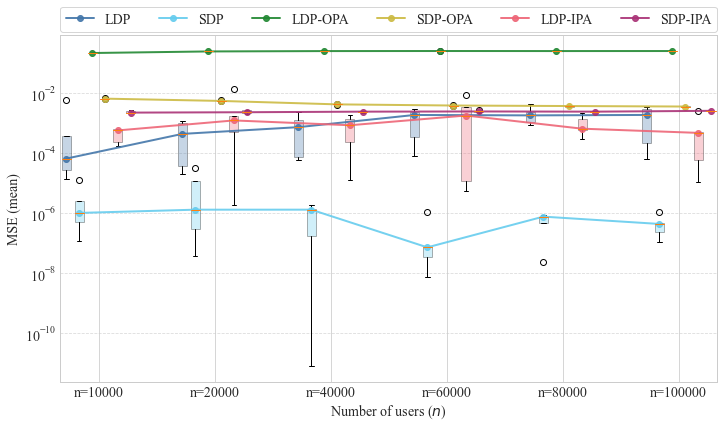

In [35]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

############################
# 1. GRR 逻辑与聚合函数  #
############################

def grr_client(value, epsilon=0.5, num_bins=100):
    """ 
    给定单个用户的真实数值 value ∈ [0,1]，
    将其映射到 num_bins 段，使用 GRR 输出扰动后的 bin 索引。
    """
    true_bin = int(value * num_bins)
    if true_bin >= num_bins:
        true_bin = num_bins - 1

    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    rand_draw = np.random.rand()
    if rand_draw < p:
        reported_bin = true_bin
    else:
        other_bins = list(range(k))
        other_bins.remove(true_bin)
        reported_bin = np.random.choice(other_bins)
    return reported_bin

def grr_aggregator(reported_bins, epsilon=0.5, num_bins=100):
    """
    聚合方：根据所有用户上报的 bin 索引 counts，估计最终的均值 (mean)。
    """
    counts = np.zeros(num_bins, dtype=int)
    for b in reported_bins:
        counts[b] += 1

    n = len(reported_bins)
    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    freq_obs = counts / float(n)
    est_prob = np.maximum(0, (freq_obs - q) / (p - q))
    s = est_prob.sum()
    if s > 0:
        est_prob /= s
    else:
        est_prob = np.ones(k) / k  # 兜底

    bin_midpoints = [(i + 0.5) / k for i in range(k)]
    estimated_mean = np.sum(est_prob * bin_midpoints)
    return estimated_mean

############################
# 2. 单次实验：区分攻击模式 #
############################

def run_one_experiment(
    n, epsilon, shuffle_amplify=False,
    malicious_mode=0, malicious_ratio=0.1,
    num_bins=100, seed=None
):
    """
    单次实验:
      - n: 用户总数
      - epsilon: 名义隐私参数
      - shuffle_amplify=True => epsilon' = epsilon + 0.5 ln(n)
      - malicious_mode:
          0 => 无恶意用户
          1 => 恶意用户可直接提交最大 bin (OPA)
          2 => 恶意用户只能将输入=1.0 后再执行GRR (IPA)
      - malicious_ratio=0.1 => 10% 恶意
    返回 (true_mean, est_mean, mse).
    """
    if seed is not None:
        np.random.seed(seed)

    # 1. 生成真实数据
    true_values = np.random.rand(n)
    true_mean = np.mean(true_values)

    # 2. 放大 (Shuffle DP)
    if shuffle_amplify:
        epsilon_eff = epsilon + 0.5 * np.log(n)
    else:
        epsilon_eff = epsilon

    # 3. 恶意用户
    if malicious_mode == 0:
        malicious_indices = set()
    else:
        num_mal = int(malicious_ratio * n)
        indices = np.arange(n)
        np.random.shuffle(indices)
        malicious_indices = set(indices[:num_mal])

    # 4. 上报 bins
    reported_bins = []
    for i in range(n):
        if i in malicious_indices:
            if malicious_mode == 1:
                # 直接提交最大 bin
                rb = num_bins - 1
            elif malicious_mode == 2:
                # 伪造输入=1.0，再走GRR
                rb = grr_client(1.0, epsilon=epsilon_eff, num_bins=num_bins)
            else:
                rb = grr_client(true_values[i], epsilon=epsilon_eff, num_bins=num_bins)
        else:
            rb = grr_client(true_values[i], epsilon=epsilon_eff, num_bins=num_bins)
        reported_bins.append(rb)

    est_mean = grr_aggregator(reported_bins, epsilon=epsilon_eff, num_bins=num_bins)
    mse = (est_mean - true_mean)**2
    return true_mean, est_mean, mse

############################
# 3. 多次实验：每组参数 -> MSE分布 #
############################

def run_experiments_for_mode(
    n_values, epsilon, malicious_mode, shuffle_amplify,
    malicious_ratio=0.1, num_bins=100, num_runs=5, seed=42
):
    """
    针对特定恶意模式 malicious_mode、是否 shuffle_amplify
    在不同 n_values 下重复实验 num_runs 次，返回 MSE列表 (二维：len(n_values) × num_runs)
    """
    rng = np.random.RandomState(seed)
    all_mses = []
    for n in n_values:
        run_mses = []
        for _ in range(num_runs):
            run_seed = rng.randint(10**9)
            _, _, mse = run_one_experiment(
                n=n, epsilon=epsilon, shuffle_amplify=shuffle_amplify,
                malicious_mode=malicious_mode, malicious_ratio=malicious_ratio,
                num_bins=num_bins, seed=run_seed
            )
            run_mses.append(mse)
        all_mses.append(run_mses)
    return all_mses  # len(n_values) × num_runs

############################
# 4. 主流程：画箱线图 + 中位数折线 #
############################

def main():
    # 一些美化设置
    plt.style.use('seaborn-whitegrid')
    matplotlib.rcParams['font.family'] = 'Times New Roman'
    matplotlib.rcParams['font.size'] = 14
    matplotlib.rcParams['axes.labelsize'] = 14
    matplotlib.rcParams['axes.titlesize'] = 14
    matplotlib.rcParams['legend.fontsize'] = 14
    matplotlib.rcParams['lines.linewidth'] = 2

    # 配置
    epsilon = 0.5
    malicious_ratio = 0.1
    n_values = [10**4, 2*10**4,  4*10**4, 6*10**4,  8*10**4, 10**5]
    num_bins = 100
    num_runs = 5

    # 对应的6列标签: 
    # 1) LDP (no malicious)
    # 2) SDP (no malicious)
    # 3) LDP-OPA (10% OPA)
    # 4) SDP-OPA (10% OPA)
    # 5) LDP-IPA (10% IPA)
    # 6) SDP-IPA (10% IPA)
    scenario_list = [
        (0, False, "LDP"),      # no malicious
        (0, True,  "SDP"),
        (1, False, "LDP-OPA"),  # malicious OPA
        (1, True,  "SDP-OPA"),
        (2, False, "LDP-IPA"),  # malicious IPA
        (2, True,  "SDP-IPA")
    ]

    # 如果想改颜色，可自定义6种颜色
    # 这里给出一组更明显且能区分的色彩：
    colors = [
        "#4477AA",  # LDP
        "#66CCEE",  # SDP
        "#228833",  # LDP-OPA
        "#CCBB44",  # SDP-OPA
        "#EE6677",  # LDP-IPA
        "#AA3377",  # SDP-IPA
    ]

    # data_for_box: 共 3 * 6 = 18 列
    data_for_box = []
    positions = []
    x_labels = []
    line_data = {}  # (scenario_key) -> (x[], median[])

    group_gap = 9  # 每组 n 的宽度

    # 收集数据
    for i_n, n in enumerate(n_values):
        base_x = i_n * group_gap
        for j, (m_mode, shf, label_str) in enumerate(scenario_list):
            box_x = base_x + (j + 1)

            # 获取 MSE
            mse_runs_2d = run_experiments_for_mode(
                n_values=[n],
                epsilon=epsilon,
                malicious_mode=m_mode,
                shuffle_amplify=shf,
                malicious_ratio=malicious_ratio,
                num_bins=num_bins,
                num_runs=num_runs,
                seed=1234 + 100*i_n + j
            )
            # mse_runs_2d[0] => 对应 n_values=[n] 只有一个 n
            mse_list = mse_runs_2d[0]

            data_for_box.append(mse_list)
            positions.append(box_x)
            x_labels.append("")  # 不在这里标 x 轴

            median_val = np.median(mse_list)
            if label_str not in line_data:
                line_data[label_str] = ([], [])
            line_data[label_str][0].append(box_x)
            line_data[label_str][1].append(median_val)

    # 绘图
    plt.figure(figsize=(10.7,6.5))

    bp = plt.boxplot(
        data_for_box,
        positions=positions,
        widths=0.7,
        patch_artist=True,
        showfliers=True
    )

    # 给箱线着色
    for i, box in enumerate(bp['boxes']):
        j = i % 6  # 第几列(0~5)
        box.set(facecolor=colors[j], alpha=0.3)

    # 在箱线图上连中位数折线
    for idx, (label_str) in enumerate(line_data.keys()):
        xs, meds = line_data[label_str]
        plt.plot(xs, meds, marker='o', color=colors[idx],
                 label=label_str, alpha=0.9)

    # x 轴每组的中心
    x_ticks = []
    x_tick_labels = []
    for i_n, n in enumerate(n_values):
        center_x = i_n * group_gap + 3.5  # 1..6 => 平均(1+6)/2=3.5
        x_ticks.append(center_x)
        x_tick_labels.append(f"n={n}")

    plt.xticks(x_ticks, x_tick_labels)
    plt.yscale('log')
    plt.xlabel("Number of users ($n$)")
    plt.ylabel("MSE (mean)")
#     plt.title("LDP vs. SDP under Different Malicious Scenarios\n(Boxplot + Median Trend)")

    # 将图例放在上方居中，单行
    plt.legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.01),
        ncol=6,  # 3 列
        borderaxespad=0,
        frameon=True
    )

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 给上方图例留空间
    plt.savefig("my_figure3.pdf", dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()


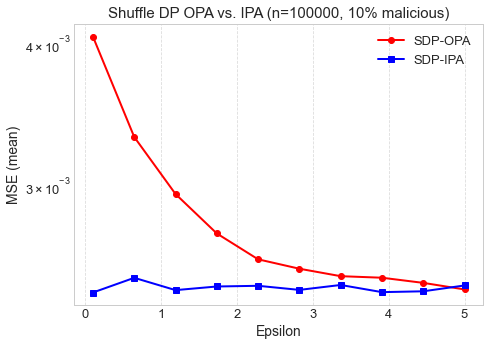

In [26]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def grr_client(value, epsilon=0.5, num_bins=100):
    """ 
    给定单个用户的真实数值 value ∈ [0,1]，
    将其映射到 num_bins 段，使用 GRR 输出扰动后的 bin 索引。
    """
    true_bin = int(value * num_bins)
    if true_bin >= num_bins:
        true_bin = num_bins - 1

    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    rand_draw = np.random.rand()
    if rand_draw < p:
        reported_bin = true_bin
    else:
        other_bins = list(range(k))
        other_bins.remove(true_bin)
        reported_bin = np.random.choice(other_bins)
    return reported_bin

def grr_aggregator(reported_bins, epsilon=0.5, num_bins=100):
    """
    聚合方：根据所有用户上报的 bin 索引 counts，估计最终的均值 (mean)。
    """
    counts = np.zeros(num_bins, dtype=int)
    for b in reported_bins:
        counts[b] += 1

    n = len(reported_bins)
    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    freq_obs = counts / float(n)
    est_prob = np.maximum(0, (freq_obs - q) / (p - q))
    s = est_prob.sum()
    if s > 0:
        est_prob /= s
    else:
        est_prob = np.ones(k) / k

    bin_midpoints = [(i + 0.5) / k for i in range(k)]
    estimated_mean = np.sum(est_prob * bin_midpoints)
    return estimated_mean

def run_one_experiment(
    n=10**5, epsilon=0.5, shuffle_amplify=True,
    malicious_mode=1, malicious_ratio=0.1,
    num_bins=100, seed=None
):
    """
    单次实验:
    - n: 用户总数，固定 10^5
    - epsilon: 本地名义隐私参数
    - shuffle_amplify=True => epsilon_eff = epsilon + 0.5 ln(n) (Shuffle DP)
    - malicious_mode:
        1 => 恶意用户可直接提交最大 bin (SDP-OPA)
        2 => 恶意用户只能将输入=1.0后再执行GRR (SDP-IPA)
    - malicious_ratio=0.1 => 10% 恶意
    """
    if seed is not None:
        np.random.seed(seed)

    # 1. 生成真实数据
    true_values = np.random.rand(n)
    true_mean = np.mean(true_values)

    # 2. Shuffle DP 放大
    if shuffle_amplify:
        epsilon_eff = epsilon + 0.5 * np.log(n)
    else:
        epsilon_eff = epsilon

    # 3. 恶意用户索引
    num_mal = int(malicious_ratio * n)
    indices = np.arange(n)
    np.random.shuffle(indices)
    malicious_indices = set(indices[:num_mal])

    # 4. 上报 bins
    reported_bins = []
    for i in range(n):
        if i in malicious_indices:
            if malicious_mode == 1:
                # OPA: 直接提交最大 bin
                rb = num_bins - 1
            elif malicious_mode == 2:
                # IPA: 伪造输入=1.0，再执行GRR
                rb = grr_client(1.0, epsilon=epsilon_eff, num_bins=num_bins)
            else:
                rb = grr_client(true_values[i], epsilon=epsilon_eff, num_bins=num_bins)
        else:
            rb = grr_client(true_values[i], epsilon=epsilon_eff, num_bins=num_bins)
        reported_bins.append(rb)

    # 5. 聚合方估计
    est_mean = grr_aggregator(reported_bins, epsilon=epsilon_eff, num_bins=num_bins)
    mse = (est_mean - true_mean)**2
    return true_mean, est_mean, mse

def run_experiments_for_epsilon(epsilons, malicious_mode, num_bins=100,
                                n=10**5, malicious_ratio=0.1,
                                shuffle_amplify=True, num_runs=5, seed=42):
    """
    在给定一组 epsilons 下，对同一 malicious_mode (1=OPA / 2=IPA) 
    进行多次重复实验，返回每个 epsilon 对应的 MSE 列表(长度=epsilons)。
    """
    rng = np.random.RandomState(seed)
    mse_means = []
    for eps in epsilons:
        run_mses = []
        for _ in range(num_runs):
            run_seed = rng.randint(1e9)
            _, _, mse = run_one_experiment(
                n=n, epsilon=eps,
                shuffle_amplify=shuffle_amplify,
                malicious_mode=malicious_mode,
                malicious_ratio=malicious_ratio,
                num_bins=num_bins,
                seed=run_seed
            )
            run_mses.append(mse)
        # 取平均 MSE
        mse_means.append(np.mean(run_mses))
    return mse_means

def main():
    plt.style.use('seaborn-whitegrid')
    matplotlib.rcParams['font.size'] = 13
    matplotlib.rcParams['axes.labelsize'] = 14
    matplotlib.rcParams['axes.titlesize'] = 15
    matplotlib.rcParams['legend.fontsize'] = 13
    matplotlib.rcParams['lines.linewidth'] = 2

    # 固定 n=10^5
    n = 10**5
    # epsilons: 从 0.1 到 5, 取10个点
    epsilons = np.linspace(0.1, 5, 10)

    # 分别对 SDP-OPA (malicious_mode=1) 和 SDP-IPA (malicious_mode=2) 做测试
    # shuffle_amplify=True => Shuffle DP
    # 10% 恶意
    mse_opa = run_experiments_for_epsilon(
        epsilons=epsilons, 
        malicious_mode=1,  # OPA
        n=n,
        shuffle_amplify=True,
        malicious_ratio=0.1,
        num_runs=5,
        seed=42
    )
    mse_ipa = run_experiments_for_epsilon(
        epsilons=epsilons,
        malicious_mode=2,  # IPA
        n=n,
        shuffle_amplify=True,
        malicious_ratio=0.1,
        num_runs=5,
        seed=999
    )

    # 绘图
    plt.figure(figsize=(7,5))
    plt.plot(epsilons, mse_opa, marker='o', color='red', label='SDP-OPA')
    plt.plot(epsilons, mse_ipa, marker='s', color='blue', label='SDP-IPA')
    plt.xscale('linear')  # 也可 log
    plt.yscale('log')     # 误差量级常用log方便观察
    plt.xlabel('Epsilon')
    plt.ylabel('MSE (mean)')
    plt.title(f'Shuffle DP OPA vs. IPA (n={n}, 10% malicious)')
    plt.grid(True, axis='both', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


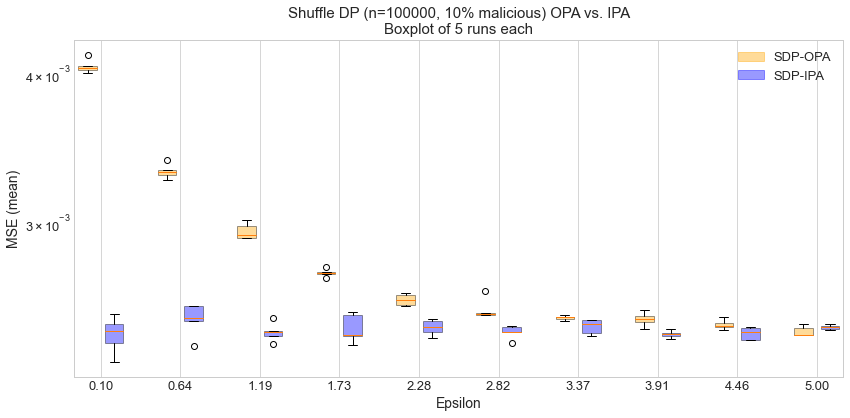

In [27]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

###########################
# 1. GRR 逻辑与聚合函数   #
###########################

def grr_client(value, epsilon=0.5, num_bins=100):
    """ 
    给定单个用户的真实数值 value ∈ [0,1]，
    将其映射到 num_bins 段，使用 GRR 输出扰动后的 bin 索引。
    """
    true_bin = int(value * num_bins)
    if true_bin >= num_bins:
        true_bin = num_bins - 1

    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    rand_draw = np.random.rand()
    if rand_draw < p:
        reported_bin = true_bin
    else:
        other_bins = list(range(k))
        other_bins.remove(true_bin)
        reported_bin = np.random.choice(other_bins)
    return reported_bin

def grr_aggregator(reported_bins, epsilon=0.5, num_bins=100):
    """
    聚合方：根据所有用户上报的 bin 索引 (counts)，估计最终的均值 (mean)。
    """
    counts = np.zeros(num_bins, dtype=int)
    for b in reported_bins:
        counts[b] += 1

    n = len(reported_bins)
    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    freq_obs = counts / float(n)
    est_prob = np.maximum(0, (freq_obs - q) / (p - q))
    s = est_prob.sum()
    if s > 0:
        est_prob /= s
    else:
        est_prob = np.ones(k) / k  # 兜底

    bin_midpoints = [(i + 0.5) / k for i in range(k)]
    estimated_mean = np.sum(est_prob * bin_midpoints)
    return estimated_mean

###########################
# 2. 单次实验: SDP-OPA / IPA #
###########################

def run_one_experiment(n=10**5, epsilon=0.5, malicious_mode=1,
                       malicious_ratio=0.1, num_bins=100, seed=None):
    """
    单次实验:
      - n=10^5
      - epsilon: 本地名义隐私参数
      - malicious_mode:
          1 => 恶意用户可直接提交最大 bin (SDP-OPA)
          2 => 恶意用户只能将输入=1.0 后再执行GRR (SDP-IPA)
      - malicious_ratio=0.1 => 10% 恶意
      - Shuffle DP 放大 => epsilon_eff = epsilon + 0.5 ln(n)
    返回 (true_mean, est_mean, mse).
    """
    if seed is not None:
        np.random.seed(seed)

    # 1. 生成真实数据
    true_values = np.random.rand(n)
    true_mean = np.mean(true_values)

    # 2. Shuffle DP 放大
    epsilon_eff = epsilon + 0.5 * np.log(n)

    # 3. 恶意用户
    num_mal = int(malicious_ratio * n)
    indices = np.arange(n)
    np.random.shuffle(indices)
    malicious_indices = set(indices[:num_mal])

    # 4. 上报 bins
    reported_bins = []
    for i in range(n):
        if i in malicious_indices:
            if malicious_mode == 1:
                # OPA: 恶意用户直接上报最大 bin
                rb = num_bins - 1
            elif malicious_mode == 2:
                # IPA: 恶意用户将输入=1.0，再执行 GRR
                rb = grr_client(1.0, epsilon=epsilon_eff, num_bins=num_bins)
            else:
                rb = grr_client(true_values[i], epsilon=epsilon_eff, num_bins=num_bins)
        else:
            # 诚实用户
            rb = grr_client(true_values[i], epsilon=epsilon_eff, num_bins=num_bins)
        reported_bins.append(rb)

    # 5. 聚合方估计
    est_mean = grr_aggregator(reported_bins, epsilon=epsilon_eff, num_bins=num_bins)
    mse = (est_mean - true_mean)**2
    return true_mean, est_mean, mse

###########################
# 3. 多次实验: 为每个epsilon测5次 #
###########################

def run_experiments_for_epsilon(epsilons, malicious_mode, n=10**5,
                                malicious_ratio=0.1, num_bins=100,
                                num_runs=5, seed=42):
    """
    给定一组 epsilons, 对固定 malicious_mode (SDP-OPA / SDP-IPA)，
    执行多次实验(每个epsilon重复num_runs次)。返回二维列表: len(epsilons) × num_runs
    """
    rng = np.random.RandomState(seed)
    all_eps_mses = []
    for e in epsilons:
        mses = []
        for _ in range(num_runs):
            run_seed = rng.randint(1e9)
            _, _, mse = run_one_experiment(
                n=n,
                epsilon=e,
                malicious_mode=malicious_mode,
                malicious_ratio=malicious_ratio,
                num_bins=num_bins,
                seed=run_seed
            )
            mses.append(mse)
        all_eps_mses.append(mses)
    return all_eps_mses  # shape=[len(epsilons), num_runs]

###########################
# 4. 主流程：箱线图 (Boxplot)  #
###########################

def main():
    plt.style.use('seaborn-whitegrid')
    matplotlib.rcParams['font.size'] = 13
    matplotlib.rcParams['axes.labelsize'] = 14
    matplotlib.rcParams['axes.titlesize'] = 15
    matplotlib.rcParams['legend.fontsize'] = 13
    matplotlib.rcParams['lines.linewidth'] = 2

    # 固定 n=10^5, 10% 恶意
    n = 10**5
    malicious_ratio = 0.1
    num_bins = 100
    num_runs = 5

    # epsilons: 从 0.1 到 5 取10个点
    epsilons = np.linspace(0.1, 5, 10)

    # 获取 SDP-OPA (malicious_mode=1) 在不同 epsilon 下的5次误差
    opa_mses = run_experiments_for_epsilon(
        epsilons=epsilons,
        malicious_mode=1,  # OPA
        n=n,
        malicious_ratio=malicious_ratio,
        num_bins=num_bins,
        num_runs=num_runs,
        seed=42
    )
    # 获取 SDP-IPA (malicious_mode=2) 在不同 epsilon 下的5次误差
    ipa_mses = run_experiments_for_epsilon(
        epsilons=epsilons,
        malicious_mode=2,  # IPA
        n=n,
        malicious_ratio=malicious_ratio,
        num_bins=num_bins,
        num_runs=num_runs,
        seed=999
    )

    # 现在我们要画箱线图: 每个 epsilon 有两列 (OPA / IPA)
    data_for_box = []
    positions = []
    x_labels = []
    group_gap = 3  # 每组 epsilon 占用的水平空间

    for i, e in enumerate(epsilons):
        base_x = i * group_gap
        # OPA
        box_x_opa = base_x + 1
        data_for_box.append(opa_mses[i])  # 该epsilon下的5次误差
        positions.append(box_x_opa)
        x_labels.append("")

        # IPA
        box_x_ipa = base_x + 2
        data_for_box.append(ipa_mses[i])
        positions.append(box_x_ipa)
        x_labels.append("")

    # 开始绘图
    plt.figure(figsize=(6,3))
    bp = plt.boxplot(
        data_for_box,
        positions=positions,
        widths=0.7,
        patch_artist=True,
        showfliers=True,
        labels=x_labels
    )

    # 着色：交替给 OPA / IPA 不同颜色
    # OPA 在偶数下标 i%2=0, IPA 在奇数下标 i%2=1
    for i, box in enumerate(bp['boxes']):
        if i % 2 == 0:
            box.set(facecolor='orange', alpha=0.4)  # OPA
        else:
            box.set(facecolor='blue', alpha=0.4)    # IPA

    # 设置 x 轴，使每组 epsilons 在中心处打上刻度
    x_ticks = []
    x_tick_labels = []
    for i, e in enumerate(epsilons):
        center_x = i * group_gap + 1.5
        x_ticks.append(center_x)
        x_tick_labels.append(f"{e:.2f}")

    plt.xticks(x_ticks, x_tick_labels)
    plt.yscale('log')
    plt.xlabel("\varepsilon")
    plt.ylabel("MSE (mean)")
#     plt.title(f"Shuffle DP (n={n}, 10% malicious) OPA vs. IPA\nBoxplot of 5 runs each")

    # 做一个自定义图例
    # 可以画两个虚拟的矩形去说明颜色
    import matplotlib.patches as mpatches
    patch_opa = mpatches.Patch(color='orange', alpha=0.4, label='SDP-OPA')
    patch_ipa = mpatches.Patch(color='blue', alpha=0.4, label='SDP-IPA')
    plt.legend(handles=[patch_opa, patch_ipa], loc='best')

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


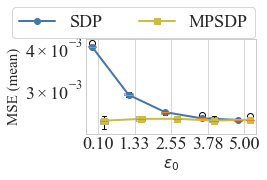

In [43]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

###########################
# 1. GRR 逻辑与聚合函数   #
###########################

def grr_client(value, epsilon=0.5, num_bins=100):
    """ 
    给定单个用户的真实数值 value ∈ [0,1]，
    将其映射到 num_bins 段，使用 GRR 输出扰动后的 bin 索引。
    """
    true_bin = int(value * num_bins)
    if true_bin >= num_bins:
        true_bin = num_bins - 1

    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    rand_draw = np.random.rand()
    if rand_draw < p:
        reported_bin = true_bin
    else:
        other_bins = list(range(k))
        other_bins.remove(true_bin)
        reported_bin = np.random.choice(other_bins)
    return reported_bin

def grr_aggregator(reported_bins, epsilon=0.5, num_bins=100):
    """
    聚合方：根据所有用户上报的 bin 索引 (counts)，估计最终的均值 (mean)。
    """
    counts = np.zeros(num_bins, dtype=int)
    for b in reported_bins:
        counts[b] += 1

    n = len(reported_bins)
    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    freq_obs = counts / float(n)
    est_prob = np.maximum(0, (freq_obs - q) / (p - q))
    s = est_prob.sum()
    if s > 0:
        est_prob /= s
    else:
        est_prob = np.ones(k) / k  # 兜底

    bin_midpoints = [(i + 0.5) / k for i in range(k)]
    estimated_mean = np.sum(est_prob * bin_midpoints)
    return estimated_mean

###########################
# 2. 单次实验: SDP / MPSDP  #
###########################

def run_one_experiment(n=10**5, epsilon=0.5, malicious_scenario='SDP',
                       malicious_ratio=0.1, num_bins=100, seed=None):
    """
    单次实验:
      - n=10^5
      - epsilon: 本地名义隐私参数 (0.1 ~ 5)
      - malicious_scenario ∈ {'SDP', 'MPSDP'}
         => 'SDP'  恶意用户可直接上报最大bin
         => 'MPSDP' 恶意用户只能将输入=1.0再执行GRR
      - malicious_ratio=0.1 => 10% 恶意
      - Shuffle DP放大 => epsilon_eff = epsilon + 0.5 ln(n)
    返回 (true_mean, est_mean, mse).
    """
    if seed is not None:
        np.random.seed(seed)

    # 1. 生成真实数据
    true_values = np.random.rand(n)
    true_mean = np.mean(true_values)

    # 2. Shuffle DP 放大
    epsilon_eff = epsilon + 0.5 * np.log(n)

    # 3. 选取恶意用户
    num_mal = int(malicious_ratio * n)
    indices = np.arange(n)
    np.random.shuffle(indices)
    malicious_indices = set(indices[:num_mal])

    # 4. 上报 bins
    reported_bins = []
    for i in range(n):
        if i in malicious_indices:
            if malicious_scenario == 'SDP':
                # SDP: 恶意用户可直接上报最大bin
                rb = num_bins - 1
            elif malicious_scenario == 'MPSDP':
                # MPSDP: 恶意用户将输入=1.0后执行GRR
                rb = grr_client(1.0, epsilon=epsilon_eff, num_bins=num_bins)
            else:
                rb = grr_client(true_values[i], epsilon=epsilon_eff, num_bins=num_bins)
        else:
            rb = grr_client(true_values[i], epsilon=epsilon_eff, num_bins=num_bins)

        reported_bins.append(rb)

    # 5. 聚合估计
    est_mean = grr_aggregator(reported_bins, epsilon=epsilon_eff, num_bins=num_bins)
    mse = (est_mean - true_mean)**2
    return true_mean, est_mean, mse

#############################
# 3. 多epsilon 多次实验      #
#############################

def run_experiments_for_epsilon(epsilons, scenario='SDP', n=10**5,
                                malicious_ratio=0.1, num_bins=100,
                                num_runs=5, seed=42):
    """
    给定一组 epsilons, 对固定 scenario ('SDP' or 'MPSDP')，重复 num_runs 次实验，
    返回二维列表: len(epsilons) × num_runs
    """
    rng = np.random.RandomState(seed)
    all_eps_mses = []
    for e in epsilons:
        mses = []
        for _ in range(num_runs):
            run_seed = rng.randint(1e9)
            _, _, mse = run_one_experiment(
                n=n,
                epsilon=e,
                malicious_scenario=scenario,
                malicious_ratio=malicious_ratio,
                num_bins=num_bins,
                seed=run_seed
            )
            mses.append(mse)
        all_eps_mses.append(mses)
    return all_eps_mses

##############################
# 4. 主流程：箱线图+折线趋势  #
##############################

def main():
    plt.style.use('seaborn-whitegrid')
    matplotlib.rcParams['font.family'] = 'Times New Roman'  # 可选：Times New Roman 字体
    matplotlib.rcParams['font.size'] = 18
    matplotlib.rcParams['axes.labelsize'] = 15
    matplotlib.rcParams['axes.titlesize'] = 18
    matplotlib.rcParams['legend.fontsize'] = 18
    matplotlib.rcParams['lines.linewidth'] = 2

    # 固定 n=10^5, 10% 恶意
    n = 10**5
    malicious_ratio = 0.1
    num_bins = 100
    num_runs = 5

    # epsilons: [0.1, 5]等间隔 10个点
    epsilons = np.linspace(0.1, 5, 5)

    # SDP
    sdp_mses2d = run_experiments_for_epsilon(
        epsilons=epsilons,
        scenario='SDP',
        n=n,
        malicious_ratio=malicious_ratio,
        num_bins=num_bins,
        num_runs=num_runs,
        seed=42
    )
    # MPSDP
    mpsdp_mses2d = run_experiments_for_epsilon(
        epsilons=epsilons,
        scenario='MPSDP',
        n=n,
        malicious_ratio=malicious_ratio,
        num_bins=num_bins,
        num_runs=num_runs,
        seed=999
    )

    # data_for_box: 共 len(epsilons)*2 列(2场景: SDP & MPSDP)
    data_for_box = []
    positions = []
    # 用来连接折线
    sdp_line_x, sdp_line_med = [], []
    mpsdp_line_x, mpsdp_line_med = [], []

    group_gap = 3

    for i, e in enumerate(epsilons):
        base_x = i*group_gap
        # SDP 在 base_x + 1
        sdp_box_x = base_x + 1
        sdp_mses = sdp_mses2d[i]  # 该epsilon下的 num_runs=5个MSE
        data_for_box.append(sdp_mses)
        positions.append(sdp_box_x)
        # 计算中位数
        sdp_med = np.median(sdp_mses)
        sdp_line_x.append(sdp_box_x)
        sdp_line_med.append(sdp_med)

        # MPSDP 在 base_x + 2
        mpsdp_box_x = base_x + 2
        mpsdp_mses = mpsdp_mses2d[i]
        data_for_box.append(mpsdp_mses)
        positions.append(mpsdp_box_x)
        # 计算中位数
        mpsdp_med = np.median(mpsdp_mses)
        mpsdp_line_x.append(mpsdp_box_x)
        mpsdp_line_med.append(mpsdp_med)

    # 绘制箱线图
    plt.figure(figsize=(4,3))
    bp = plt.boxplot(
        data_for_box,
        positions=positions,
        widths=0.7,
        patch_artist=True,
        showfliers=True
    )

    # 着色: 偶数列 => SDP, 奇数列 => MPSDP
    # (i=0 => SDP, i=1 => MPSDP, i=2=>SDP, i=3=>MPSDP, ...)
    for i, box in enumerate(bp['boxes']):
        if i % 2 == 0:
            # SDP
            box.set(facecolor='#4477AA', alpha=0.3)
        else:
            # MPSDP
            box.set(facecolor='#CCBB44', alpha=0.3)

    # 折线：SDP (蓝) + MPSDP (橙)
    plt.plot(sdp_line_x, sdp_line_med, marker='o', color='#4477AA',
             label='SDP', linestyle='-')
    plt.plot(mpsdp_line_x, mpsdp_line_med, marker='s', color='#CCBB44',
             label='MPSDP', linestyle='-')

    # 设置 x 轴：每组中点
    x_ticks = []
    x_labels = []
    for i, e in enumerate(epsilons):
        center_x = i*group_gap + 1.5
        x_ticks.append(center_x)
        x_labels.append(f"{e:.2f}")

    plt.xticks(x_ticks, x_labels)

    plt.yscale('log')
    plt.xlabel("$\\varepsilon_0$")
    plt.ylabel("MSE (mean)")
#     plt.title(f"SDP vs. MPSDP (n={n}, 10% malicious)\nBoxplot + Median Trend")

    # 将图例放在顶部中间
    plt.legend(
        loc='lower center', 
        bbox_to_anchor=(0.28, 1.01),
        ncol=2,  # 两个标签并排
        borderaxespad=0,
        frameon=True
    )

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 留出顶部空间给图例
    plt.savefig("sec_epsilon.pdf", dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()


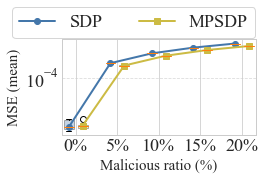

In [49]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

###########################
# 1. GRR 逻辑与聚合函数   #
###########################

def grr_client(value, epsilon=0.5, num_bins=100):
    """ 
    给定单个用户的真实数值 value ∈ [0,1]，
    将其映射到 num_bins 段，使用 GRR 输出扰动后的 bin 索引。
    """
    true_bin = int(value * num_bins)
    if true_bin >= num_bins:
        true_bin = num_bins - 1

    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    rand_draw = np.random.rand()
    if rand_draw < p:
        reported_bin = true_bin
    else:
        other_bins = list(range(k))
        other_bins.remove(true_bin)
        reported_bin = np.random.choice(other_bins)
    return reported_bin

def grr_aggregator(reported_bins, epsilon=0.5, num_bins=100):
    """
    聚合方：根据所有用户上报的 bin 索引 (counts)，估计最终的均值 (mean)。
    """
    counts = np.zeros(num_bins, dtype=int)
    for b in reported_bins:
        counts[b] += 1

    n = len(reported_bins)
    k = num_bins
    exp_epsilon = np.exp(epsilon)
    p = exp_epsilon / (exp_epsilon + k - 1)
    q = 1.0 / (exp_epsilon + k - 1)

    freq_obs = counts / float(n)
    est_prob = np.maximum(0, (freq_obs - q) / (p - q))
    s = est_prob.sum()
    if s > 0:
        est_prob /= s
    else:
        est_prob = np.ones(k) / k  # 兜底

    bin_midpoints = [(i + 0.5) / k for i in range(k)]
    estimated_mean = np.sum(est_prob * bin_midpoints)
    return estimated_mean

###########################
# 2. 单次实验: SDP-OPA / IPA #
###########################

def run_one_experiment(n=10**5, epsilon=0.5, malicious_mode=1,
                       malicious_ratio=0.1, num_bins=100, seed=None):
    """
    单次实验:
      - n=10^5
      - epsilon=0.5 (名义), Shuffle DP 放大 => eps_eff = epsilon + 0.5 ln(n)
      - malicious_mode: 1 => OPA, 2 => IPA
      - malicious_ratio => 恶意用户占比
    """
    if seed is not None:
        np.random.seed(seed)

    # 1. 生成真实数据
    true_values = np.random.rand(n)
    true_mean = np.mean(true_values)

    # 2. Shuffle DP 放大
    epsilon_eff = epsilon + 0.5 * np.log(n)

    # 3. 恶意用户索引
    num_mal = int(malicious_ratio * n)
    indices = np.arange(n)
    np.random.shuffle(indices)
    malicious_indices = set(indices[:num_mal])

    # 4. 上报 bins
    reported_bins = []
    for i in range(n):
        if i in malicious_indices:
            if malicious_mode == 1:
                # OPA: 直接上报最大 bin
                rb = num_bins - 1
            elif malicious_mode == 2:
                # IPA: 将输入=1.0再执行 GRR
                rb = grr_client(1.0, epsilon=epsilon_eff, num_bins=num_bins)
            else:
                rb = grr_client(true_values[i], epsilon=epsilon_eff, num_bins=num_bins)
        else:
            rb = grr_client(true_values[i], epsilon=epsilon_eff, num_bins=num_bins)
        reported_bins.append(rb)

    # 5. 聚合估计
    est_mean = grr_aggregator(reported_bins, epsilon=epsilon_eff, num_bins=num_bins)
    mse = (est_mean - true_mean)**2
    return true_mean, est_mean, mse

###############################
# 3. 多次实验: 不同恶意比例   #
###############################

def run_experiments_for_malratio(mal_ratios, mode=1, n=10**5,
                                 epsilon=0.5, num_bins=100,
                                 num_runs=5, seed=42):
    """
    给定一组恶意比例 mal_ratios, 对某一攻击模式 mode=1(OPA)/2(IPA)，
    固定 n, epsilon=0.5 (Shuffle放大), 重复 num_runs 次,
    返回: len(mal_ratios) × num_runs 的 MSE列表.
    """
    rng = np.random.RandomState(seed)
    all_mses2d = []
    for mr in mal_ratios:
        mses = []
        for _ in range(num_runs):
            run_seed = rng.randint(1e9)
            _, _, mse = run_one_experiment(
                n=n,
                epsilon=epsilon,
                malicious_mode=mode,
                malicious_ratio=mr,
                num_bins=num_bins,
                seed=run_seed
            )
            mses.append(mse)
        all_mses2d.append(mses)
    return all_mses2d

###############################
# 4. 主流程：箱线图 + 折线趋势  #
###############################

def main():
    plt.style.use('seaborn-whitegrid')
    matplotlib.rcParams['font.family'] = 'Times New Roman'  # 可选：Times New Roman 字体
    matplotlib.rcParams['font.size'] = 18
    matplotlib.rcParams['axes.labelsize'] = 15
    matplotlib.rcParams['axes.titlesize'] = 18
    matplotlib.rcParams['legend.fontsize'] = 18
    matplotlib.rcParams['lines.linewidth'] = 2

    n = 10**5
    epsilon = 0.5
    num_bins = 100
    num_runs = 5

    # 恶意用户从 0 到 2e4 => 占比 [0, 0.05, 0.1, 0.15, 0.2]
    mal_ratios = [0.0, 0.05, 0.1, 0.15, 0.2]

    # 分别获取 OPA (mode=1) 和 IPA (mode=2) 情形下各恶意比例的 5 次 MSE
    opa_mses2d = run_experiments_for_malratio(
        mal_ratios=mal_ratios,
        mode=1,  # OPA
        n=n,
        epsilon=epsilon,
        num_bins=num_bins,
        num_runs=num_runs,
        seed=42
    )
    ipa_mses2d = run_experiments_for_malratio(
        mal_ratios=mal_ratios,
        mode=2,  # IPA
        n=n,
        epsilon=epsilon,
        num_bins=num_bins,
        num_runs=num_runs,
        seed=999
    )

    # data_for_box: 2列 × 5组 => 10列
    # group i => mal_ratios[i], 左列=OPA, 右列=IPA
    data_for_box = []
    positions = []

    # 记录折线： (x坐标[], median[]) => OPA/IPA
    opa_line_x, opa_line_med = [], []
    ipa_line_x, ipa_line_med = [], []

    group_gap = 3
    for i, mr in enumerate(mal_ratios):
        base_x = i*group_gap
        # OPA
        box_x_opa = base_x + 1
        mses_opa = opa_mses2d[i]  # 5次
        data_for_box.append(mses_opa)
        positions.append(box_x_opa)
        opa_median = np.median(mses_opa)
        opa_line_x.append(box_x_opa)
        opa_line_med.append(opa_median)

        # IPA
        box_x_ipa = base_x + 2
        mses_ipa = ipa_mses2d[i]
        data_for_box.append(mses_ipa)
        positions.append(box_x_ipa)
        ipa_median = np.median(mses_ipa)
        ipa_line_x.append(box_x_ipa)
        ipa_line_med.append(ipa_median)

    plt.figure(figsize=(4,3))
    bp = plt.boxplot(
        data_for_box,
        positions=positions,
        widths=0.7,
        patch_artist=True,
        showfliers=True
    )

    # 给箱线着色: 偶数(OPA)、奇数(IPA)
    for j, box in enumerate(bp['boxes']):
        if j % 2 == 0:
            # OPA => 偶数
            box.set(facecolor='#4477AA', alpha=0.3)
        else:
            # IPA => 奇数
            box.set(facecolor='#CCBB44', alpha=0.3)

    # 折线：OPA 用暗蓝, IPA 用暗橙
    plt.plot(opa_line_x, opa_line_med, marker='o', color='#4477AA', label='SDP')
    plt.plot(ipa_line_x, ipa_line_med, marker='s', color='#CCBB44', label='MPSDP')

    # x 轴
    x_ticks = []
    x_tick_labels = []
    for i, mr in enumerate(mal_ratios):
        center_x = i*group_gap + 1.5
        x_ticks.append(center_x)
        x_tick_labels.append(f"{mr*100:.0f}%")

    plt.xticks(x_ticks, x_tick_labels)
    plt.yscale('log')
    plt.xlabel("Malicious ratio (%)")
    plt.ylabel("MSE (mean)")
#     plt.title(f"SDP-OPA vs. SDP-IPA under n={n}, eps={epsilon}\nBoxplot + Median Trend")

    # 图例放在顶部
    plt.legend(
        loc='lower center', 
        bbox_to_anchor=(0.37, 1.01),
        ncol=2,  # 两个标签并排
        borderaxespad=0,
        frameon=True
    )

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 留出顶部空间给图例
    plt.savefig("sec_nc.pdf", dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()


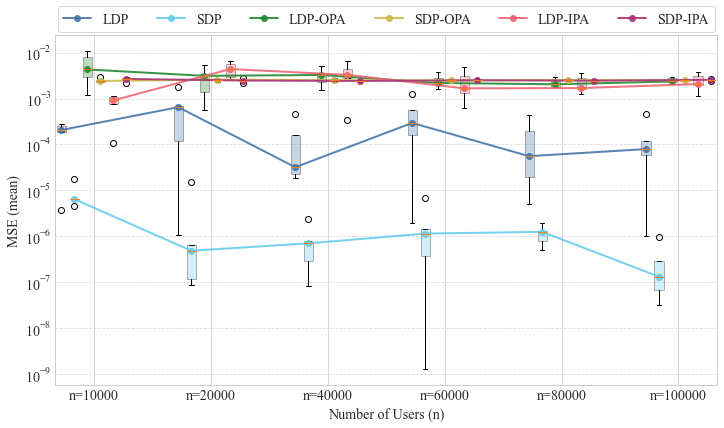

In [52]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

############################
# 1. Laplace 逻辑与聚合函数 #
############################

def laplace_client(value, epsilon=0.5):
    """
    给定单个用户的真实数值 value ∈ [0,1]，
    使用 Laplace(0, 1/epsilon) 生成扰动后的值并返回。
    其中 epsilon 可以是本地 or 放大后的有效 epsilon。
    """
    b = 1.0 / epsilon  # 拉普拉斯噪声尺度
    noise = np.random.laplace(loc=0.0, scale=b)
    noisy_value = value + noise
    
    # 可选：是否需要截断到 [0,1], 视需求而定
    # noisy_value = min(max(noisy_value, 0.0), 1.0)
    
    return noisy_value

def laplace_aggregator(reported_values):
    """
    聚合方：对所有用户上报的带拉普拉斯噪声的数值取平均，
    作为最终均值估计。
    """
    n = len(reported_values)
    est_mean = np.mean(reported_values)
    return est_mean

############################
# 2. 单次实验：区分攻击模式 #
############################

def run_one_experiment(
    n, epsilon, shuffle_amplify=False,
    malicious_mode=0, malicious_ratio=0.1,
    seed=None
):
    """
    单次实验:
      - n: 用户总数
      - epsilon: 名义隐私参数
      - shuffle_amplify=True => epsilon_eff = epsilon + 0.5 ln(n)
      - malicious_mode:
          0 => 无恶意用户
          1 => 恶意用户可直接提交最大值 1 (OPA)
          2 => 恶意用户只能将输入=1.0 后再执行 Laplace (IPA)
      - malicious_ratio=0.1 => 10% 恶意
    返回 (true_mean, est_mean, mse).
    """
    if seed is not None:
        np.random.seed(seed)

    # 1. 生成真实数据
    true_values = np.random.rand(n)  # ∈ [0,1]
    true_mean = np.mean(true_values)

    # 2. 放大 (Shuffle DP)
    if shuffle_amplify:
        epsilon_eff = epsilon + 0.5 * np.log(n)
    else:
        epsilon_eff = epsilon

    # 3. 恶意用户
    if malicious_mode == 0:
        malicious_indices = set()
    else:
        num_mal = int(malicious_ratio * n)
        indices = np.arange(n)
        np.random.shuffle(indices)
        malicious_indices = set(indices[:num_mal])

    # 4. 上报的带噪声值
    reported_values = []
    for i in range(n):
        if i in malicious_indices:
            if malicious_mode == 1:
                # OPA: 直接上报 1.0，无噪声
                val_report = 1.0
            elif malicious_mode == 2:
                # IPA: 先将输入=1.0，然后加 Laplace
                val_report = laplace_client(1.0, epsilon=epsilon_eff)
            else:
                # 理论不会到这
                val_report = laplace_client(true_values[i], epsilon=epsilon_eff)
        else:
            # 诚实用户
            val_report = laplace_client(true_values[i], epsilon=epsilon_eff)
        reported_values.append(val_report)

    # 5. 聚合方估计
    est_mean = laplace_aggregator(reported_values)
    mse = (est_mean - true_mean)**2
    return true_mean, est_mean, mse

############################
# 3. 多次实验：每组参数 -> MSE分布 #
############################

def run_experiments_for_mode(
    n_values, epsilon, malicious_mode, shuffle_amplify,
    malicious_ratio=0.1, num_runs=5, seed=42
):
    """
    针对特定恶意模式 malicious_mode、是否 shuffle_amplify
    在不同 n_values 下重复实验 num_runs 次，返回 MSE列表 (二维：len(n_values) × num_runs)
    """
    rng = np.random.RandomState(seed)
    all_mses = []
    for n in n_values:
        run_mses = []
        for _ in range(num_runs):
            run_seed = rng.randint(10**9)
            _, _, mse = run_one_experiment(
                n=n, epsilon=epsilon, shuffle_amplify=shuffle_amplify,
                malicious_mode=malicious_mode, malicious_ratio=malicious_ratio,
                seed=run_seed
            )
            run_mses.append(mse)
        all_mses.append(run_mses)
    return all_mses  # len(n_values) × num_runs

############################
# 4. 主流程：画箱线图 + 中位数折线 #
############################

def main():
    plt.style.use('seaborn-whitegrid')
    matplotlib.rcParams['font.family'] = 'Times New Roman'
    matplotlib.rcParams['font.size'] = 14
    matplotlib.rcParams['axes.labelsize'] = 14
    matplotlib.rcParams['axes.titlesize'] = 14
    matplotlib.rcParams['legend.fontsize'] = 14
    matplotlib.rcParams['lines.linewidth'] = 2


    # 配置
    epsilon = 0.5
    malicious_ratio = 0.1
    n_values = [10**4, 2*10**4,  4*10**4, 6*10**4,  8*10**4, 10**5]
    num_runs = 5

    # 对应的6列标签: 
    # 1) LDP (no malicious)
    # 2) SDP (no malicious)
    # 3) LDP-OPA (10% OPA)
    # 4) SDP-OPA (10% OPA)
    # 5) LDP-IPA (10% IPA)
    # 6) SDP-IPA (10% IPA)
    scenario_list = [
        (0, False, "LDP"),      # no malicious
        (0, True,  "SDP"),
        (1, False, "LDP-OPA"),  # malicious OPA
        (1, True,  "SDP-OPA"),
        (2, False, "LDP-IPA"),  # malicious IPA
        (2, True,  "SDP-IPA")
    ]

    # 定制6种颜色
    colors = [
        "#4477AA",  # LDP
        "#66CCEE",  # SDP
        "#228833",  # LDP-OPA
        "#CCBB44",  # SDP-OPA
        "#EE6677",  # LDP-IPA
        "#AA3377",  # SDP-IPA
    ]

    data_for_box = []
    positions = []
    x_labels = []
    line_data = {}

    group_gap = 9  # 每组 n 的宽度

    for i_n, n in enumerate(n_values):
        base_x = i_n * group_gap
        for j, (m_mode, shf, label_str) in enumerate(scenario_list):
            box_x = base_x + (j + 1)
            # 获取 MSE
            mse_runs_2d = run_experiments_for_mode(
                n_values=[n],
                epsilon=epsilon,
                malicious_mode=m_mode,
                shuffle_amplify=shf,
                malicious_ratio=malicious_ratio,
                num_runs=num_runs,
                seed=1234 + 100*i_n + j
            )
            # mse_runs_2d[0] => 对应 n_values=[n] 只有一个 n
            mse_list = mse_runs_2d[0]

            data_for_box.append(mse_list)
            positions.append(box_x)
            x_labels.append("")  # x 轴刻度后面统一设置

            median_val = np.median(mse_list)
            if label_str not in line_data:
                line_data[label_str] = ([], [])
            line_data[label_str][0].append(box_x)
            line_data[label_str][1].append(median_val)

    plt.figure(figsize=(10.7,6.5))

    bp = plt.boxplot(
        data_for_box,
        positions=positions,
        widths=0.7,
        patch_artist=True,
        showfliers=True
    )

    # 给箱线着色
    for i, box in enumerate(bp['boxes']):
        j = i % 6  # 第几列(0~5)
        box.set(facecolor=colors[j], alpha=0.3)

    # 折线
    for idx, (label_str) in enumerate(line_data.keys()):
        xs, meds = line_data[label_str]
        plt.plot(xs, meds, marker='o', color=colors[idx],
                 label=label_str, alpha=0.9)

    # x 轴刻度
    x_ticks = []
    x_tick_labels = []
    for i_n, n in enumerate(n_values):
        center_x = i_n * group_gap + 3.5
        x_ticks.append(center_x)
        x_tick_labels.append(f"n={n}")

    plt.xticks(x_ticks, x_tick_labels)
    plt.yscale('log')
    plt.xlabel("Number of Users (n)")
    plt.ylabel("MSE (mean)")
#     plt.title("LDP vs. SDP under Different Malicious Scenarios (Laplace)\n(Boxplot + Median Trend)")

    # 图例放顶部
    plt.legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.01),
        ncol=6,  # 3 列
        borderaxespad=0,
        frameon=True
    )

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 给上方图例留空间
    plt.savefig("lap.pdf", dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()


In [53]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

############################
# 1. Laplace 逻辑与聚合函数 #
############################

def laplace_client(value, epsilon=0.5):
    """
    给定单个用户的真实数值 value ∈ [0,1]，
    使用拉普拉斯噪声 (scale=1/epsilon) 生成扰动值并返回。
    """
    b = 1.0 / epsilon
    noise = np.random.laplace(loc=0.0, scale=b)
    noisy_value = value + noise
    # 可选：是否截断到 [0,1]，视需求而定
    # noisy_value = max(0, min(1, noisy_value))
    return noisy_value

def laplace_aggregator(reported_values):
    """
    聚合方：对所有用户的带噪声上报值做简单平均
    作为对真实均值的估计。
    """
    est_mean = np.mean(reported_values)
    return est_mean

############################
# 2. 单次实验：区分攻击模式 #
############################

def run_one_experiment(
    n, epsilon, shuffle_amplify=False,
    malicious_mode=0, malicious_ratio=0.1,
    seed=None
):
    """
    单次实验:
      - n: 用户总数
      - epsilon: 名义隐私参数
      - shuffle_amplify=True => epsilon_eff = epsilon + 0.5 ln(n)
      - malicious_mode:
          0 => 无恶意用户
          1 => 恶意用户可直接提交最大值1 (OPA)
          2 => 恶意用户只能将输入=1.0后再进行Laplace扰动 (IPA)
      - malicious_ratio=0.1 或 0.15 => 恶意比例
    返回 (true_mean, est_mean, mse).
    """
    if seed is not None:
        np.random.seed(seed)

    # 1. 生成真实数据
    true_values = np.random.rand(n)
    true_mean = np.mean(true_values)

    # 2. 放大 (Shuffle DP)
    if shuffle_amplify:
        epsilon_eff = epsilon + 0.5 * np.log(n)
    else:
        epsilon_eff = epsilon

    # 3. 确定恶意用户
    if malicious_mode == 0:
        malicious_indices = set()
    else:
        num_mal = int(malicious_ratio * n)
        indices = np.arange(n)
        np.random.shuffle(indices)
        malicious_indices = set(indices[:num_mal])

    # 4. 上报值 (Laplace机制+可能恶意)
    reported_values = []
    for i in range(n):
        if i in malicious_indices:
            if malicious_mode == 1:
                # OPA: 直接上报1.0 (无噪声)
                val_report = 1.0
            elif malicious_mode == 2:
                # IPA: 先把输入=1.0，再加Laplace扰动
                val_report = laplace_client(1.0, epsilon=epsilon_eff)
            else:
                # 理论上不会到这里
                val_report = laplace_client(true_values[i], epsilon=epsilon_eff)
        else:
            # 诚实用户: 按真实值加Laplace
            val_report = laplace_client(true_values[i], epsilon=epsilon_eff)
        reported_values.append(val_report)

    # 5. 聚合方估计
    est_mean = laplace_aggregator(reported_values)
    mse = (est_mean - true_mean)**2
    return true_mean, est_mean, mse

############################
# 3. 多次实验：每组参数 -> MSE分布 #
############################

def run_experiments_for_mode(
    n_values, epsilon, malicious_mode, shuffle_amplify,
    malicious_ratio=0.1, num_runs=5, seed=42
):
    """
    针对特定恶意模式 malicious_mode、是否 shuffle_amplify
    在不同 n_values 下重复实验 num_runs 次，返回 MSE列表 (二维：len(n_values) × num_runs)
    """
    rng = np.random.RandomState(seed)
    all_mses = []
    for n in n_values:
        run_mses = []
        for _ in range(num_runs):
            run_seed = rng.randint(10**9)
            _, _, mse = run_one_experiment(
                n=n, epsilon=epsilon, shuffle_amplify=shuffle_amplify,
                malicious_mode=malicious_mode, malicious_ratio=malicious_ratio,
                seed=run_seed
            )
            run_mses.append(mse)
        all_mses.append(run_mses)
    return all_mses  # len(n_values) × num_runs

############################
# 4. 主流程：画箱线图 + 中位数折线 #
############################

def main():
    plt.style.use('seaborn-whitegrid')
    matplotlib.rcParams['font.family'] = 'Times New Roman'  # 设置字体为 Times New Roman
    matplotlib.rcParams['font.size'] = 14
    matplotlib.rcParams['axes.labelsize'] = 14
    matplotlib.rcParams['axes.titlesize'] = 14
    matplotlib.rcParams['legend.fontsize'] = 14
    matplotlib.rcParams['lines.linewidth'] = 2

    # 配置
    epsilon = 0.5
    n_values = [10**4, 2*10**4,  4*10**4, 6*10**4,  8*10**4, 10**5]
    num_bins = 100
    num_runs = 5

    # 对应的6列标签: 
    # 1) LDP (no malicious)
    # 2) SDP (no malicious)
    # 3) LDP-OPA (10% OPA)
    # 4) SDP-OPA (15% OPA)
    # 5) LDP-IPA (10% IPA)
    # 6) SDP-IPA (15% IPA)
    scenario_list = [
        (0, False, "LDP"),      # no malicious, malicious_ratio=0.1
        (0, True,  "SDP"),      # no malicious, malicious_ratio=0.15
        (1, False, "LDP-OPA"),  # OPA, malicious_ratio=0.1
        (1, True,  "SDP-OPA"),  # OPA, malicious_ratio=0.15
        (2, False, "LDP-IPA"),  # IPA, malicious_ratio=0.1
        (2, True,  "SDP-IPA")   # IPA, malicious_ratio=0.15
    ]

    # 定制6种颜色
    colors = [
        "#4477AA",  # LDP
        "#66CCEE",  # SDP
        "#228833",  # LDP-OPA
        "#CCBB44",  # SDP-OPA
        "#EE6677",  # LDP-IPA
        "#AA3377",  # SDP-IPA
    ]

    data_for_box = []
    positions = []
    x_labels = []
    line_data = {}

    group_gap = 9  # 每组 n 的宽度

    for i_n, n in enumerate(n_values):
        base_x = i_n * group_gap
        for j, (m_mode, shf, label_str) in enumerate(scenario_list):
            box_x = base_x + (j + 1)
            
            # 设置恶意用户比例
            if shf:
                current_mal_ratio = 0.15  # SDP场景
            else:
                current_mal_ratio = 0.10  # LDP场景
            
            # 获取 MSE
            mse_runs_2d = run_experiments_for_mode(
                n_values=[n],
                epsilon=epsilon,
                malicious_mode=m_mode,
                shuffle_amplify=shf,
                malicious_ratio=current_mal_ratio,
                num_bins=num_bins,
                num_runs=num_runs,
                seed=1234 + 100*i_n + j
            )
            # mse_runs_2d[0] => 对应 n_values=[n] 只有一个 n
            mse_list = mse_runs_2d[0]

            data_for_box.append(mse_list)
            positions.append(box_x)
            x_labels.append("")  # x 轴刻度后统一设置

            median_val = np.median(mse_list)
            if label_str not in line_data:
                line_data[label_str] = ([], [])
            line_data[label_str][0].append(box_x)
            line_data[label_str][1].append(median_val)

    plt.figure(figsize=(12,7))

    bp = plt.boxplot(
        data_for_box,
        positions=positions,
        widths=0.7,
        patch_artist=True,
        showfliers=True
    )

    # 给箱线着色
    for i, box in enumerate(bp['boxes']):
        j = i % 6  # 第几列(0~5)
        box.set(facecolor=colors[j], alpha=0.3)

    # 绘制折线趋势
    for idx, (label_str) in enumerate(line_data.keys()):
        xs, meds = line_data[label_str]
        plt.plot(xs, meds, marker='o', color=colors[idx],
                 label=label_str, alpha=0.9)

    # 设置 x 轴刻度
    x_ticks = []
    x_tick_labels = []
    for i_n, n in enumerate(n_values):
        center_x = i_n * group_gap + 3.5  # 每组中心位置
        x_ticks.append(center_x)
        x_tick_labels.append(f"n={n}")

    plt.xticks(x_ticks, x_tick_labels)
    plt.yscale('log')
    plt.xlabel("Number of users ($n$)")
    plt.ylabel("MSE (mean)")
#     plt.title("LDP vs. SDP under Different Malicious Scenarios (Laplace, LDP:10% | SDP:15%)\n(Boxplot + Median Trend)")

    # 图例放在顶部居中，单行
    plt.legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.01),
        ncol=6,  # 3 列
        borderaxespad=0,
        frameon=True
    )

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 给上方图例留空间
    plt.savefig("lap2.pdf", dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()


TypeError: run_experiments_for_mode() got an unexpected keyword argument 'num_bins'

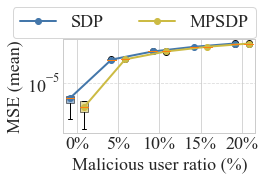

In [75]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

############################
# 1. 拉普拉斯 逻辑与聚合函数 #
############################

def laplace_client(values, epsilon):
    """
    给定用户的真实数值数组 values ∈ [0,1]，
    使用拉普拉斯噪声 (scale=1/epsilon) 生成扰动后的值并返回。
    """
    scale = 1.0 / epsilon
    noise = np.random.laplace(loc=0.0, scale=scale, size=values.shape)
    noisy_values = values + noise
    # 可选：截断到 [0,1]
    # noisy_values = np.clip(noisy_values, 0.0, 1.0)
    return noisy_values

def laplace_aggregator(reported_values):
    """
    聚合方：对所有用户上报的带噪声数值取平均，作为均值估计。
    """
    est_mean = np.mean(reported_values)
    return est_mean

############################
# 2. 单次实验：SDP-OPA / SDP-IPA #
############################

def run_one_experiment(
    n=10**5, epsilon=0.5, malicious_mode='OPA',
    malicious_ratio=0.1, seed=None
):
    """
    单次实验:
      - n: 用户总数 (固定为1e5)
      - epsilon: 隐私参数
      - malicious_mode: 'OPA' 或 'IPA'
      - malicious_ratio: 恶意用户比例 (如0.0, 0.05, ..., 0.2)
      - seed: 随机种子
    返回 (true_mean, est_mean, mse).
    """
    if seed is not None:
        np.random.seed(seed)

    # 1. 生成真实数据
    true_values = np.random.rand(n)
    true_mean = np.mean(true_values)

    # 2. Shuffle DP 放大
    epsilon_eff = epsilon + 0.5 * np.log(n)

    # 3. 确定恶意用户
    num_mal = int(malicious_ratio * n)
    malicious_indices = set(np.random.choice(n, size=num_mal, replace=False))

    # 4. 上报值
    reported_values = np.empty(n)
    # 诚实用户
    honest_indices = np.array(list(set(range(n)) - malicious_indices))
    reported_values[honest_indices] = laplace_client(true_values[honest_indices], epsilon_eff)

    # 恶意用户
    if malicious_mode == 'OPA':
        # OPA: 恶意用户直接上报1.0
        reported_values[list(malicious_indices)] = 1.0
    elif malicious_mode == 'IPA':
        # IPA: 恶意用户将输入设为1.0后加噪声
        reported_values[list(malicious_indices)] = laplace_client(
            np.ones(num_mal), epsilon_eff
        )
    else:
        raise ValueError("malicious_mode 必须是 'OPA' 或 'IPA'")

    # 5. 聚合估计
    est_mean = laplace_aggregator(reported_values)
    mse = (est_mean - true_mean) ** 2
    return true_mean, est_mean, mse

###############################
# 3. 多次实验: 不同恶意比例   #
###############################

def run_experiments(
    mal_ratios, modes, n=10**5, epsilon=0.5,
    num_runs=5, seed=42
):
    """
    运行多次实验，获取每种恶意比例和攻击模式下的MSE。
    参数:
      - mal_ratios: 恶意用户比例列表 (如 [0.0, 0.05, 0.1, 0.15, 0.2])
      - modes: 攻击模式列表 (['OPA', 'IPA'])
      - n: 用户总数
      - epsilon: 隐私参数
      - num_runs: 每种组合的实验次数
      - seed: 随机种子
    返回:
      - results: 字典，键为模式，值为每个恶意比例的MSE列表
    """
    rng = np.random.RandomState(seed)
    results = {mode: {mr: [] for mr in mal_ratios} for mode in modes}

    for mode in modes:
        for mr in mal_ratios:
            for run in range(num_runs):
                run_seed = rng.randint(1e9)
                _, _, mse = run_one_experiment(
                    n=n, epsilon=epsilon, malicious_mode=mode,
                    malicious_ratio=mr, seed=run_seed
                )
                results[mode][mr].append(mse)
    return results

############################
# 4. 主流程：画箱线图 + 折线趋势 #
############################

def main():
    # 配置
    n = 10**5
    epsilon = 0.5
    num_runs = 5
    mal_ratios = [0.0, 0.05, 0.1, 0.15, 0.2]
    modes = ['OPA', 'IPA']

    # 运行实验
    results = run_experiments(
        mal_ratios=mal_ratios,
        modes=modes,
        n=n,
        epsilon=epsilon,
        num_runs=num_runs,
        seed=42
    )

    # 准备绘图数据
    data_for_box = []
    positions = []
    labels = []
    color_map = {
        'OPA': '#4477AA',   # 蓝色
        'IPA': '#CCBB44'    # 橙色
    }
    median_data = {'OPA': [], 'IPA': []}
    position_data = {'OPA': [], 'IPA': []}

    group_gap = 3  # 每组恶意比例的水平间隔

    for i, mr in enumerate(mal_ratios):
        base_x = i * group_gap

        for mode in modes:
            box_x = base_x + (0 if mode == 'OPA' else 1)
            mse_list = results[mode][mr]
            data_for_box.append(mse_list)
            positions.append(box_x)

            # 记录中位数
            median_val = np.median(mse_list)
            median_data[mode].append(median_val)
            position_data[mode].append(box_x)

    # 绘制箱线图
    plt.figure(figsize=(4,3))
    bp = plt.boxplot(
        data_for_box,
        positions=positions,
        widths=0.6,
        patch_artist=True,
        showfliers=True
    )

    # 给箱线着色
    for i, box in enumerate(bp['boxes']):
        mode = 'OPA' if i % 2 == 0 else 'IPA'
        box.set(facecolor=color_map[mode], alpha=0.5)

    # 绘制中位数折线
    for mode in modes:
        txt = ''
        if mode == 'OPA':
            txt = 'SDP'
        else:
            txt = 'MPSDP'
        plt.plot(
            position_data[mode],
            median_data[mode],
            marker='o',
            color=color_map[mode],
            label=txt
        )

    # 设置 x 轴
    x_ticks = []
    x_tick_labels = []
    for i, mr in enumerate(mal_ratios):
        center_x = i * group_gap + 0.5  # 两个模式 (OPA=0, IPA=1)
        x_ticks.append(center_x)
        x_tick_labels.append(f"{int(mr*100)}%")

    plt.xticks(x_ticks, x_tick_labels)
    plt.xlabel("Malicious user ratio (%)", fontsize=18)
    plt.ylabel("MSE (mean)", fontsize=18)
#     plt.title("SDP-OPA vs. SDP-IPA under Different Malicious Ratios (n=10^5, ε=0.5)\n(Laplace Mechanism)", fontsize=16)
    plt.yscale('log')

    # 图例放在顶部
    plt.legend(
        loc='lower center', 
        bbox_to_anchor=(0.37, 1.01),
        ncol=2,  # 两个标签并排
        borderaxespad=0,
        frameon=True
    )

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 留出顶部空间给图例
    plt.savefig("sec_nc2.pdf", dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()


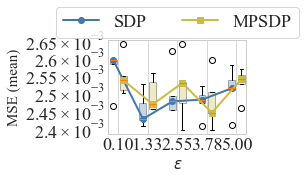

In [65]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

############################
# 1. 拉普拉斯 逻辑与聚合函数 #
############################

def laplace_client(value, epsilon=0.5):
    """
    给定单个用户的真实数值 value ∈ [0,1]，
    使用拉普拉斯噪声 (scale=1/epsilon) 生成扰动值并返回。
    """
    scale = 1.0 / epsilon
    noise = np.random.laplace(loc=0.0, scale=scale)
    noisy_value = value + noise
    # 可选：截断到 [0,1]
    # noisy_value = np.clip(noisy_value, 0.0, 1.0)
    return noisy_value

def laplace_aggregator(reported_values):
    """
    聚合方：对所有用户上报的带噪声数值取平均，
    作为对真实均值的估计。
    """
    est_mean = np.mean(reported_values)
    return est_mean

############################
# 2. 单次实验: SDP / MPSDP #
############################

def run_one_experiment(n=10**5, epsilon=0.5, malicious_scenario='SDP',
                       malicious_ratio=0.1, seed=None):
    """
    单次实验:
      - n=10^5
      - epsilon: 隐私参数 (0.1 ~ 5)
      - malicious_scenario ∈ {'SDP', 'MPSDP'}
         => 'SDP'    恶意用户可直接上报最大值1.0 (OPA)
         => 'MPSDP'  恶意用户将输入=1.0后执行拉普拉斯扰动 (IPA)
      - malicious_ratio=0.1 => 10% 恶意用户
      - Shuffle DP放大 => epsilon_eff = epsilon + 0.5 ln(n)
    返回 (true_mean, est_mean, mse).
    """
    if seed is not None:
        np.random.seed(seed)

    # 1. 生成真实数据
    true_values = np.random.rand(n)
    true_mean = np.mean(true_values)

    # 2. Shuffle DP 放大
    epsilon_eff = epsilon + 0.5 * np.log(n)

    # 3. 选取恶意用户
    num_mal = int(malicious_ratio * n)
    malicious_indices = set(np.random.choice(n, size=num_mal, replace=False))

    # 4. 上报值
    reported_values = np.empty(n)
    
    # 诚实用户
    honest_indices = np.array(list(set(range(n)) - malicious_indices))
    reported_values[honest_indices] = [
        laplace_client(val, epsilon_eff) for val in true_values[honest_indices]
    ]

    # 恶意用户
    if malicious_scenario == 'SDP':
        # SDP: 恶意用户可直接上报最大值1.0 (OPA)
        reported_values[list(malicious_indices)] = 1.0
    elif malicious_scenario == 'MPSDP':
        # MPSDP: 恶意用户将输入=1.0后执行拉普拉斯扰动 (IPA)
        reported_values[list(malicious_indices)] = [
            laplace_client(1.0, epsilon_eff) for _ in malicious_indices
        ]
    else:
        raise ValueError("malicious_scenario 必须是 'SDP' 或 'MPSDP'")

    # 5. 聚合估计
    est_mean = laplace_aggregator(reported_values)
    mse = (est_mean - true_mean) ** 2
    return true_mean, est_mean, mse

###############################
# 3. 多epsilon 多次实验      #
###############################

def run_experiments_for_epsilon(epsilons, scenario='SDP', n=10**5,
                                malicious_ratio=0.1, num_runs=5, seed=42):
    """
    给定一组 epsilons, 对固定 scenario ('SDP' or 'MPSDP')，重复 num_runs 次实验，
    返回二维列表: len(epsilons) × num_runs
    """
    rng = np.random.RandomState(seed)
    all_eps_mses = []
    for e in epsilons:
        mses = []
        for _ in range(num_runs):
            run_seed = rng.randint(1e9)
            _, _, mse = run_one_experiment(
                n=n,
                epsilon=e,
                malicious_scenario=scenario,
                malicious_ratio=malicious_ratio,
                seed=run_seed
            )
            mses.append(mse)
        all_eps_mses.append(mses)
    return all_eps_mses

##############################
# 4. 主流程：箱线图+折线趋势  #
##############################

def main():
    plt.style.use('seaborn-whitegrid')
    matplotlib.rcParams['font.family'] = 'Times New Roman'  # 设置字体为 Times New Roman
    matplotlib.rcParams['font.size'] = 18
    matplotlib.rcParams['axes.labelsize'] = 15
    matplotlib.rcParams['axes.titlesize'] = 18
    matplotlib.rcParams['legend.fontsize'] = 18
    matplotlib.rcParams['lines.linewidth'] = 2

    # 固定参数
    n = 10**5
    malicious_ratio = 0.1
    num_runs = 5

    # epsilons: [0.1, 5] 等间隔 5个点
    epsilons = np.linspace(0.1, 5, 5)

    # 运行实验
    # SDP: 恶意用户可直接上报最大值 (OPA)
    sdp_mses2d = run_experiments_for_epsilon(
        epsilons=epsilons,
        scenario='SDP',
        n=n,
        malicious_ratio=malicious_ratio,
        num_runs=num_runs,
        seed=42
    )
    # MPSDP: 恶意用户将输入=1.0后执行拉普拉斯扰动 (IPA)
    mpsdp_mses2d = run_experiments_for_epsilon(
        epsilons=epsilons,
        scenario='MPSDP',
        n=n,
        malicious_ratio=malicious_ratio,
        num_runs=num_runs,
        seed=999
    )

    # 准备绘图数据
    data_for_box = []
    positions = []
    # 用来连接折线
    sdp_line_x, sdp_line_med = [], []
    mpsdp_line_x, mpsdp_line_med = [], []

    group_gap = 3  # 每个epsilon组的水平间隔

    for i, e in enumerate(epsilons):
        base_x = i * group_gap
        # SDP 在 base_x + 1
        sdp_box_x = base_x + 1
        sdp_mses = sdp_mses2d[i]  # 该epsilon下的 num_runs=5个MSE
        data_for_box.append(sdp_mses)
        positions.append(sdp_box_x)
        # 计算中位数
        sdp_med = np.median(sdp_mses)
        sdp_line_x.append(sdp_box_x)
        sdp_line_med.append(sdp_med)

        # MPSDP 在 base_x + 2
        mpsdp_box_x = base_x + 2
        mpsdp_mses = mpsdp_mses2d[i]
        data_for_box.append(mpsdp_mses)
        positions.append(mpsdp_box_x)
        # 计算中位数
        mpsdp_med = np.median(mpsdp_mses)
        mpsdp_line_x.append(mpsdp_box_x)
        mpsdp_line_med.append(mpsdp_med)

    # 绘制箱线图
    plt.figure(figsize=(4,3))
    bp = plt.boxplot(
        data_for_box,
        positions=positions,
        widths=0.7,
        patch_artist=True,
        showfliers=True
    )

    # 给箱线着色: 偶数列 => SDP, 奇数列 => MPSDP
    # (i=0 => SDP, i=1 => MPSDP, i=2=>SDP, i=3=>MPSDP, ...)
    for i, box in enumerate(bp['boxes']):
        if i % 2 == 0:
            # SDP
            box.set(facecolor='#4477AA', alpha=0.3)
        else:
            # MPSDP
            box.set(facecolor='#CCBB44', alpha=0.3)

    # 绘制折线趋势
    plt.plot(sdp_line_x, sdp_line_med, marker='o', color='#4477AA',
             label='SDP', linestyle='-')
    plt.plot(mpsdp_line_x, mpsdp_line_med, marker='s', color='#CCBB44',
             label='MPSDP', linestyle='-')

    # 设置 x 轴刻度
    x_ticks = []
    x_labels = []
    for i, e in enumerate(epsilons):
        center_x = i * group_gap + 1.5  # 每组中心位置
        x_ticks.append(center_x)
        x_labels.append(f"{e:.2f}")

    plt.xticks(x_ticks, x_labels)
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("MSE (mean)")
#     plt.title(f"SDP vs. MPSDP under n={n}, 10% malicious\n(Boxplot + Median Trend)")

    # 图例放在顶部中间，单行
    plt.legend(
        loc='lower center',
        bbox_to_anchor=(0.5, 1.02),
        ncol=2,  # 两个标签并排
        borderaxespad=0,
        frameon=True
    )

    plt.yscale('log')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 留出顶部空间给图例
    plt.savefig("sec_epsilon_laplace.pdf", dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()


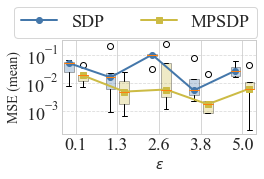

In [71]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

############################
# 1. 拉普拉斯 逻辑与聚合函数 #
############################

def laplace_client(value, epsilon=0.5):
    """
    给定单个用户的真实数值 value ∈ [0,1]，
    使用拉普拉斯噪声 (scale=1/epsilon) 生成扰动值并返回。
    """
    scale = 1.0 / epsilon
    noise = np.random.laplace(loc=0.0, scale=scale)
    noisy_value = value + noise
    return noisy_value

def laplace_aggregator(reported_values):
    """
    聚合方：对所有用户上报的带噪声数值取平均，
    作为对真实均值的估计。
    """
    # 使用 NaN 处理被删除的数据
    est_mean = np.nanmean(reported_values)
    return est_mean

############################
# 2. 单次实验: SDP / MPSDP #
############################

def run_one_experiment(n=10**5, epsilon=0.5, malicious_scenario='SDP',
                       malicious_ratio=0.1, drop_threshold=1.5, drop_prob=0.5,
                       seed=None):
    """
    单次实验:
      - n=10^5
      - epsilon: 隐私参数 (0.1 ~ 5)
      - malicious_scenario ∈ {'SDP', 'MPSDP'}
         => 'SDP'    恶意用户可直接上报最大值2.0 (OPA)
         => 'MPSDP'  恶意用户将输入=1.0后执行拉普拉斯扰动 (IPA)
      - malicious_ratio=0.1 => 10% 恶意用户
      - drop_threshold=1.5: 在 IPA 场景下，如果噪声后值 > 1.5，则以 drop_prob 概率删除
      - Shuffle DP放大 => epsilon_eff = epsilon + 0.5 ln(n)
    返回 (true_mean, est_mean, mse).
    """
    if seed is not None:
        np.random.seed(seed)

    # 1. 生成真实数据
    true_values = np.random.rand(n)
    true_mean = np.mean(true_values)

    # 2. Shuffle DP 放大
    epsilon_eff = epsilon + 0.5 * np.log(n)

    # 3. 选取恶意用户
    num_mal = int(malicious_ratio * n)
    malicious_indices = set(np.random.choice(n, size=num_mal, replace=False))

    # 4. 上报值
    reported_values = np.empty(n)
    reported_values[:] = np.nan  # 初始化为 NaN，方便后续处理

    # 诚实用户
    honest_indices = np.array(list(set(range(n)) - malicious_indices))
    reported_values[honest_indices] = laplace_client(true_values[honest_indices], epsilon_eff)

    # 恶意用户
    if malicious_scenario == 'SDP':
        # SDP: 恶意用户可直接上报最大值2.0 (OPA)
        reported_values[list(malicious_indices)] = 2.0
    elif malicious_scenario == 'MPSDP':
        # MPSDP: 恶意用户将输入=1.0后执行拉普拉斯扰动 (IPA)
        ipa_values = laplace_client(1.0, epsilon_eff)
        # 如果噪声后值 > drop_threshold，则以 drop_prob 概率删除
        if ipa_values > drop_threshold:
            if np.random.rand() < drop_prob:
                reported_values[list(malicious_indices)] = np.nan  # 删除
            else:
                reported_values[list(malicious_indices)] = ipa_values
        else:
            reported_values[list(malicious_indices)] = ipa_values
    else:
        raise ValueError("malicious_scenario 必须是 'SDP' 或 'MPSDP'")

    # 5. 聚合估计
    est_mean = laplace_aggregator(reported_values)
    mse = (est_mean - true_mean) ** 2
    return true_mean, est_mean, mse

###############################
# 3. 多epsilon 多次实验      #
###############################

def run_experiments_for_epsilon(epsilons, scenario='SDP', n=10**5,
                                malicious_ratio=0.1, num_runs=5,
                                drop_threshold=1.5, drop_prob=0.5,
                                seed=42):
    """
    给定一组 epsilons, 对固定 scenario ('SDP' or 'MPSDP')，重复 num_runs 次实验，
    返回二维列表: len(epsilons) × num_runs
    """
    rng = np.random.RandomState(seed)
    all_eps_mses = []
    for e in epsilons:
        mses = []
        for _ in range(num_runs):
            run_seed = rng.randint(1e9)
            _, _, mse = run_one_experiment(
                n=n,
                epsilon=e,
                malicious_scenario=scenario,
                malicious_ratio=malicious_ratio,
                drop_threshold=drop_threshold,
                drop_prob=drop_prob,
                seed=run_seed
            )
            mses.append(mse)
        all_eps_mses.append(mses)
    return all_eps_mses

##############################
# 4. 主流程：箱线图+折线趋势  #
##############################

def main():
    plt.style.use('seaborn-whitegrid')
    matplotlib.rcParams['font.family'] = 'Times New Roman'  # 设置字体为 Times New Roman
    matplotlib.rcParams['font.size'] = 18
    matplotlib.rcParams['axes.labelsize'] = 15
    matplotlib.rcParams['axes.titlesize'] = 18
    matplotlib.rcParams['legend.fontsize'] = 18
    matplotlib.rcParams['lines.linewidth'] = 2
    # 配置
    n = 10**5
    malicious_ratio = 0.1  # 10% 恶意用户
    num_runs = 5
    drop_threshold = 1.5  # IPA 场景下的阈值
    drop_prob = 0.5        # IPA 场景下的删除概率

    # epsilons: 从 0.1 到 5，等间隔 10 个点
    epsilons = np.linspace(0.1, 5, 5)

    # 运行实验
    # SDP: 恶意用户可直接上报最大值2.0 (OPA)
    sdp_mses2d = run_experiments_for_epsilon(
        epsilons=epsilons,
        scenario='SDP',
        n=n,
        malicious_ratio=malicious_ratio,
        num_runs=num_runs,
        seed=42
    )
    # MPSDP: 恶意用户将输入=1.0后执行拉普拉斯扰动 (IPA)
    mpsdp_mses2d = run_experiments_for_epsilon(
        epsilons=epsilons,
        scenario='MPSDP',
        n=n,
        malicious_ratio=malicious_ratio,
        drop_threshold=drop_threshold,
        drop_prob=drop_prob,
        num_runs=num_runs,
        seed=999
    )

    # 准备绘图数据
    data_for_box = []
    positions = []
    # 用来连接折线
    sdp_line_x, sdp_line_med = [], []
    mpsdp_line_x, mpsdp_line_med = [], []

    group_gap = 3  # 每个 epsilon 组的水平间隔

    for i, e in enumerate(epsilons):
        base_x = i * group_gap
        # SDP 在 base_x + 1
        sdp_box_x = base_x + 1
        sdp_mses = sdp_mses2d[i]  # 该 epsilon 下的 num_runs=5 个 MSE
        data_for_box.append(sdp_mses)
        positions.append(sdp_box_x)
        # 计算中位数
        sdp_med = np.median(sdp_mses)
        sdp_line_x.append(sdp_box_x)
        sdp_line_med.append(sdp_med)

        # MPSDP 在 base_x + 2
        mpsdp_box_x = base_x + 2
        mpsdp_mses = mpsdp_mses2d[i]
        data_for_box.append(mpsdp_mses)
        positions.append(mpsdp_box_x)
        # 计算中位数
        mpsdp_med = np.median(mpsdp_mses)
        mpsdp_line_x.append(mpsdp_box_x)
        mpsdp_line_med.append(mpsdp_med)

    # 绘制箱线图
    plt.figure(figsize=(4, 3))
    bp = plt.boxplot(
        data_for_box,
        positions=positions,
        widths=0.7,
        patch_artist=True,
        showfliers=True
    )

    # 给箱线着色: 偶数列 => SDP, 奇数列 => MPSDP
    # (i=0 => SDP, i=1 => MPSDP, i=2=>SDP, i=3=>MPSDP, ...)
    colors = ['#4477AA', '#CCBB44']  # SDP: 蓝色, MPSDP: 橙色
    for i, box in enumerate(bp['boxes']):
        color = colors[i % 2]
        box.set(facecolor=color, alpha=0.3)

    # 绘制折线趋势
    plt.plot(sdp_line_x, sdp_line_med, marker='o', color='#4477AA',
             label='SDP', linestyle='-')
    plt.plot(mpsdp_line_x, mpsdp_line_med, marker='s', color='#CCBB44',
             label='MPSDP', linestyle='-')

    # 设置 x 轴刻度
    x_ticks = []
    x_labels = []
    for i, e in enumerate(epsilons):
        center_x = i * group_gap + 1.5  # 每组中心位置
        x_ticks.append(center_x)
        x_labels.append(f"{e:.1f}")

    plt.xticks(x_ticks, x_labels)
    plt.xlabel("$\\varepsilon$", fontsize=14)
    plt.ylabel("MSE (mean)", fontsize=14)
#     plt.title(f"SDP vs. MPSDP under n={n}, 10% malicious\n(Boxplot + Median Trend)", fontsize=16)
    plt.yscale('log')

    # 图例放在顶部中间，单行
    plt.legend(
        loc='lower center',
        bbox_to_anchor=(0.38, 1.02),
        ncol=2,  # 两个标签并排
        borderaxespad=0,
        frameon=True
    )

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 留出顶部空间给图例
    plt.savefig("sec_epsilon_laplace.pdf", dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()


In [76]:
import scipy.stats as stats
from scipy.special import comb
import numpy as np
from datetime import datetime
import json
from time import process_time


def Delta(ep, alpha, r0, r1, n, p, tol=1e-12):
    rate = r0/(r0+r1)

    def fvlow(c):
        # vectorized computation for a list of c (required by scipy.stats.rv_discrete.expect)
        g01 = (1-alpha-alpha*p)*(n-(c+1))/(1-r0-r1)
        low01 = ((np.exp(ep)*p-1)*alpha*(c+1)/r1+(np.exp(ep)-1)*g01)/(alpha*(p/r0-1/r1+np.exp(ep)*(p/r1-1/r0)))
        g2 = (1-alpha-alpha*p)*(n-c)/(1-r0-r1)
        low2 = ((np.exp(ep)*p-1)*alpha*c/r1+(np.exp(ep)-1)*g2)/(alpha*(p/r0-1/r1+np.exp(ep)*(p/r1-1/r0)))

        v0 = np.array([1-stats.binom.cdf(int(np.ceil(low01[i]))-2, c[i], rate) for i in range(len(c))])
        v1 = np.array([1-stats.binom.cdf(int(np.ceil(low01[i]))-1, c[i], rate) for i in range(len(c))])
        v2 = np.array([1-stats.binom.cdf(int(np.ceil(low2[i]))-1, c[i], rate) for i in range(len(c))])

        # linear transformation (and weights are independent from c)
        p0 = p*alpha*v0+alpha*v1+(1-alpha-p*alpha)*v2
        p1 = alpha*v0+p*alpha*v1+(1-alpha-p*alpha)*v2
        return p0-np.exp(ep)*p1

    def fvhigh(c):
        g01 = (1-alpha-alpha*p)*(n-(c+1))/(1-r0-r1)
        high01 = ((np.exp(-ep)*p-1)*alpha*(c+1)/r1+(np.exp(-ep)-1)*g01)/(alpha*(p/r0-1/r1+np.exp(-ep)*(p/r1-1/r0)))
        g2 = (1-alpha-alpha*p)*(n-c)/(1-r0-r1)
        high2 = ((np.exp(-ep)*p-1)*alpha*c/r1+(np.exp(-ep)-1)*g2)/(alpha*(p/r0-1/r1+np.exp(-ep)*(p/r1-1/r0)))

        v0 = np.array([stats.binom.cdf(int(np.floor(high01[i]-1)), c[i], rate) for i in range(len(c))])
        v1 = np.array([stats.binom.cdf(int(np.floor(high01[i])), c[i], rate) for i in range(len(c))])
        v2 = np.array([stats.binom.cdf(int(np.floor(high2[i])), c[i], rate) for i in range(len(c))])

        p0 = p*alpha*v0+alpha*v1+(1-alpha-p*alpha)*v2
        p1 = alpha*v0+p*alpha*v1+(1-alpha-p*alpha)*v2
        return p1-np.exp(ep)*p0

    delta0 = stats.binom.expect(fvlow, args=(n-1, r0+r1), lb=0, ub=n-1, tolerance=tol, maxcount=n, chunksize=32)
    if r0 == r1:
        # by the symmetry of r0 and r1, delta0 always equals to delta1
        delta1 = delta0
    else:
        delta1 = stats.binom.expect(fvhigh, args=(n-1, r0+r1), lb=0, ub=n-1, tolerance=tol, maxcount=n, chunksize=32)
    #print("delta01", delta0, delta1)

    return max(delta0, delta1)


def amplificationUB(p, beta, q0, q1, n, delta, T):
    # privacy amplification upper bound
    alpha = beta/(p-1)
    r0 = alpha*p/q0
    r1 = alpha*p/q1
    return amplificationUBCore(p, alpha, r0, r1, n, delta, T)


def amplificationUBCore(p, alpha, r0, r1, n, delta, T):
    epL = 0
    epH = np.log(p) # one may also use the closed-form bound as a starting point

    # tolerance in scipy.stats.rv_discrete.expect
    tol = max(1e-19, min(1e-14, delta/n/10.0))
    for t in range(T):
        ep = (epL+epH)/2.0
        # add tol*n to delta, extremely conservative for rigidness, one may modify the scipy.stats.rv_discrete.expect to get tighter bounds
        if Delta(ep, alpha, r0, r1, n, p, tol)+tol*n   > delta:
            epL = ep
        else:
            epH = ep
    return epH


def amplificationLB(p, beta, q0, q1, n, delta, T):
    # privacy amplification lower bound
    alpha = beta/(p-1)
    r0 = alpha*p/q0
    r1 = alpha*p/q1
    return amplificationLBCore(p, alpha, r0, r1, n, delta, T)


def amplificationLBCore(p, alpha, r0, r1, n, delta, T):
    epL = 0
    epH = np.log(p)

    # tolerance in scipy.stats.rv_discrete.expect
    tol = max(1e-19, min(1e-14, delta/n/10.0))
    for t in range(T):
        ep = (epL+epH)/2.0
        # there is no tol*n, as scipy.stats.rv_discrete.expect always underestimate non-negative delta
        if Delta(ep, alpha, r0, r1, n, p, tol) > delta:
            epL = ep
        else:
            epH = ep
    return epL


def computeUBParameters(epsilon, mechanism, options):
    # variation-ratio parameters for upper bounds
    p = np.exp(epsilon)
    beta = (np.exp(epsilon)-1)/(np.exp(epsilon)+1)
    q = np.exp(epsilon)
    if mechanism in ['laplace']:
        beta = 1-np.exp(-epsilon/2)
    elif mechanism in ['piecewise']:
        beta = (np.exp(epsilon)-1)/(np.exp(epsilon)+np.exp(epsilon/2))
    elif mechanism in ['krr']:
        k = int(options)
        beta = (np.exp(epsilon)-1)/(np.exp(epsilon)+k-1)
    elif mechanism in ['subset']:
        d, k = options[0], options[1]
        beta = (np.exp(epsilon)-1)*(comb(d-1, k-1)-comb(d-2, k-2))/(np.exp(epsilon)*comb(d-1, k-1)+comb(d-1, k))
    elif mechanism in ['localhash']:
        l = int(options)
        beta = (np.exp(epsilon)-1)/(np.exp(epsilon)+l-1)
    elif mechanism in ['hardamard']:
        K, s = options[0], options[1]
        beta = (s*(np.exp(epsilon)-1)/2)/(s*np.exp(epsilon)+K-s)
    elif mechanism in ['hardamardB']:
        K, s = options[0], options[1]
        beta = (s*(np.exp(epsilon)-1))/(s*np.exp(epsilon)+K-s)
    elif mechanism in ['collision']:
        if hasattr(options, '__iter__'):
            s, l = options[0], options[1]
        else:
            s = options
            l = int(s*np.exp(epsilon)+2*s-1)
        beta = s*(np.exp(epsilon)-1)/(s*np.exp(epsilon)+l-s)
    elif mechanism in ['cheu']:
        m, epc, deltac = options[0], options[1], options[2]
        right = 33.0/5*(((np.exp(epc)+1)/(np.exp(epc)-1))**2)*np.log(4/deltac)
        assert m*m-4*m*right >= 0
        f = (m-np.sqrt(m*m-4*m*right))/(2*m) # the p in the original paper
        #print("mechanism", mechanism, m, 4*right, f)
        f = min(1/2-0.00000001, f)
        p = (1-f)**2/(f*f)
        beta = 1-2*f
        q = (1-f)/f
    elif mechanism in ['balls2bins']:
        d, s = options[0], options[1]
        p = 10**5  # simulate +inf
        beta = (p-1)/(p+1)
        q = d/s
    elif mechanism in ['krr_sep_best']:
        k = int(options)
        beta = (np.exp(epsilon)-1)/(np.exp(epsilon)+k-1)
    elif mechanism in ['krr_sep_worst']:
        k = int(options)
        beta = (np.exp(epsilon)-1)/(np.exp(epsilon)+2-1)
    elif mechanism in ['krr_para_basic']:
        k = int(options)
        beta = (np.exp(epsilon)-1)/(np.exp(epsilon)+1)
    elif mechanism in ['krr_para_advanced']:
        k = int(options)
        beta = 0
        for h in range(int(np.log2(k))):
            beta = (np.exp(epsilon)-1)/(np.exp(epsilon)+2**(h+1)-1)/int(np.log2(k))
    return p, beta, q, q



if __name__ == '__main__':
    epsilons = np.array([0.1, 1.0, 3.0, 5.0]) # local epsilon for single-message protocols
    #epsilons = np.array([1.0, 2.0, 3.0, 4.0])
    #epsilons = np.arange(0.01, 1.02, 0.03) # global epsilon for multi-message protocols


    #ms = [None] # general LDP mechanisms
    ms = [None, "laplace", "piecewise", "krr", "subset", "localhash", "hardamard", "hardamardB", "collision"]
    #ms = [None, "collision"]
    #ms = ["krr_para_advanced", "krr_para_basic", "krr_sep_best", "krr_sep_worst"] # range queries with krr
    #ms = ["cheu", "balls2bins"] # multi-message protocols

    #bounds = ["variation_ratio", "variation_ratio_closed", "variation_ratio_tightclosed", "strong_clone", "strong_clone_closed", "clone", "clone_closed",
    #"erlingsson", "erlingsson_closed", "blanket_hoeffding", "blanket_bennett", "blanket_hoeffding_generic", "blanket_bennett_generic"]
    bounds = ["variation_ratio", "variation_ratio_closed", "variation_ratio_tightclosed", "strong_clone", "strong_clone_closed", "clone_closed"]
    #bounds = ["variation_ratio", "variation_ratio_tightclosed", "variation_ratio_closed"]

    # the dict for recording amplification settings/results
    results = {}
    results["epsilons"] = epsilons.tolist()
    results["ms"] = ms

    n = 1000000
    nusers = n
    delta = 0.01/n
    # number of binary search iterations
    T = 12

    d = 100 # 64, 2048, domain size
    s = 8 # sparsity parameter for set-valued data or key-value data
    results["n"] = n
    results["delta"] = delta
    results["d"] = d
    print("epsilons, n, ms, d, s", epsilons, n, ms, (d,s))
    print("bounds", bounds)

    #filename = "unified_n"+str(n)+"_d"+str(d)+"_s"+str(s)+".json"
    filename = None  # None means don't save results to disk

    for epsilon in epsilons:
        # for single-message
        options = [None, None, None, d, (d, int(np.ceil(d/(np.exp(epsilon)+0)))), int(np.exp(epsilon)+1), (d, d/2), (d, d/2, 8), (s, int(s*np.exp(epsilon)+2*s-1))]
        #options = [None, s]

        # for range query with parallel composition on krr
        #options = [d, d, d, d]

        # for multi-message protocol
        #options = [(n, epsilon, delta), (d, s)] # options for multi-message protocols

        for mi, m in enumerate(ms):
            if m in ["balls2bins"]:
                d, s = options[mi][0], options[mi][1]
                n = int(32*np.log(2/delta)*d/s/(epsilon*epsilon)) # number of covering messages
                print(m, n, d, s)
            elif m in ['krr_sep_best', 'krr_sep_worst']:
                d = int(options[mi])
                n = int(n/np.log2(d)) # separating into sub-populations for each hierarchy
            else:
                n = nusers

            if results.get(m) is None:
                results[m] = {}
                for bound in bounds:
                    results[m][bound] = []
            if "variation_ratio" in bounds:
                p, beta, q0, q1 = computeUBParameters(epsilon=epsilon, mechanism=ms[mi], options=options[mi])
                start = process_time()
                ub = amplificationUB(p, beta, q0, q1, n, delta, T)
                end = process_time()

                results[m]["variation_ratio"].append(ub)
                #print running time
                print("running time: m, epsilon, n, process time", m, epsilon, n, end-start)
                #results[m]["time_variation_ratio"].append(end-start)

            if "variation_ratio_closed" in bounds:
                p, beta, q0, q1 = computeUBParameters(epsilon=epsilon, mechanism=ms[mi], options=options[mi])
                q = max(q0, q1)
                r = beta*p/((p-1)*q)
                aub1 = epsilon
                if n > 8*np.log(4/delta)/r:
                    c = max(0, 4*(1-3*r)/(9*(1-2*r)))
                    aub1 = np.log(1+beta/((1-c)*(1+p)*beta/(p-1)+c)*(np.sqrt(32*np.log(4/delta)/(r*(n-1)))+4/(r*(n-1))))
                results[m]["variation_ratio_closed"].append(aub1)

            if "variation_ratio_tightclosed" in bounds:
                p, beta, q0, q1 = computeUBParameters(epsilon=epsilon, mechanism=ms[mi], options=options[mi])
                q = max(q0, q1)
                alpha = beta/(p-1)
                r = alpha*p/q
                aubx = epsilon
                Omega = (n-1)*(2*r)-np.sqrt(min(6*r,1/2)*(n-1)*np.log(4/delta))
                if Omega > 0 and (p+1)*alpha/2-(1-alpha-alpha*p)*r/(1-2*r) > 0.0 and Omega > (2*p*(beta+1+(beta-1)*p)*(n-1)+beta)/(q+p*(beta-1+(beta+1)*p)-p*q):
                    alpha = beta/(p-1)
                    aubx = np.log(1+beta*(2*np.sqrt(Omega*np.log(4/delta)/2)+1)/(alpha*Omega+beta*(Omega/2-np.sqrt(Omega*np.log(4/delta)/2))+(1-alpha-alpha*p)*(n-1-Omega)*r/(1-2*r)))
                results[m]["variation_ratio_tightclosed"].append(aubx)

            if "strong_clone" in bounds:
                p = np.exp(epsilon)
                alpha = 1.0/(np.exp(epsilon)+1)
                r = 1.0/(np.exp(epsilon)+1)
                ub_sc = amplificationUBCore(p, alpha, r, r, n, delta, T)
                results[m]["strong_clone"].append(ub_sc)

            if "strong_clone_closed" in bounds:
                alpha = 1.0/(np.exp(epsilon)+1)
                r = 1.0/(np.exp(epsilon)+1)
                aub2 = epsilon
                if n > 8*np.log(4/delta)/r:
                    aub2 = np.log(1+(np.exp(epsilon)-1)/(np.exp(epsilon)+1)*(np.sqrt(32*np.log(4/delta)/(r*(n-1)))+4/(r*(n-1))))
                results[m]["strong_clone_closed"].append(aub2)

            # clone reduction, Vitaly Feldman, Audra McMillan, and Kunal Talwar. Hiding among the clones: A simple and nearly optimal analysis of privacy amplification by shuffling. In 2021 IEEE 62nd Annual Symposium on Foundations of Computer Science (FOCS), pages 954–964. IEEE, 202
            # for comparison with numerical clone, download https://github.com/apple/ml-shuffling-amplification/
            """
            if "clone" in bounds:
                import computeamplification as CA
                r = 1.0/(2*np.exp(epsilon))
                ub_c = CA.numericalanalysis(n, 2*r, epsilon, delta, T, 10, True, coin=1/2, factor=1.0)[1]
                results[m]["clone"].append(ub_c)
            """

            if "clone_closed" in bounds:
                r = 1.0/(2*np.exp(epsilon))
                aub3 = epsilon
                if n > 8*np.log(4/delta)/r:
                    aub3 = np.log(1+(np.exp(epsilon)-1)/(np.exp(epsilon)+1)*(np.sqrt(32*np.log(4/delta)/(r*(n-1)))+4/(r*(n-1))))
                results[m]["clone_closed"].append(aub3)

            # privacy blanket, B. Balle, J. Bell, A. Gascon, and K. Nissim. The Privacy Blanket of the Shuffle Model, International Cryptology Conference (CRYPTO), 2019
            # for comparison with numerical privacy blanket, download https://github.com/BorjaBalle/amplification-by-shuffling
            """
            import shuffleddp
            from shuffleddp.amplification_bounds import *
            from shuffleddp.mechanisms import *
            if shuffleddp is not None and len({"erlingsson_closed", "blanket_hoeffding", "blanket_bennett", "blanket_hoeffding_generic", "blanket_bennett_generic"}.intersection(set(bounds))) > 0:
                blanketname = m
                if m in ["collision"]:
                    blanketname += str(options[mi])
                mks = [LDPMechanism(eps0=epsilon, name=blanketname), LDPMechanism(eps0=epsilon, name="generic")]

                # This bound does not use infomation about the underlying mechanism
                erlingsson = Erlingsson()
                all_bounds = [erlingsson]

                # The other two bounds can use a 'Generic' mechanism or a specific mechanism
                bound_types = [Hoeffding, BennettExact]
                for mk in mks:
                    for B in bound_types:
                        all_bounds.append(B(mk))
                epcbounds = []
                for bi, b in enumerate(all_bounds):
                    epc = b.get_eps(epsilon, n, delta)
                    epcbounds.append(epsilon if math.isnan(epc) else epc)

                results[m]["erlingsson_closed"].append(epcbounds[0])
                results[m]["blanket_hoeffding"].append(epcbounds[1])
                results[m]["blanket_bennett"].append(epcbounds[2])
                results[m]["blanket_hoeffding_generic"].append(epcbounds[3])
                results[m]["blanket_bennett_generic"].append(epcbounds[4])
            """

            print(epsilon, m, [results[m][bound][-1] for bound in bounds],  options[mi])

    if filename is not None:
        with open(datetime.now().isoformat().replace(':', '_')+'-'+filename, 'w') as outfile:
            json.dump(results, outfile)


epsilons, n, ms, d, s [0.1 1.  3.  5. ] 1000000 [None, 'laplace', 'piecewise', 'krr', 'subset', 'localhash', 'hardamard', 'hardamardB', 'collision'] (100, 8)
bounds ['variation_ratio', 'variation_ratio_closed', 'variation_ratio_tightclosed', 'strong_clone', 'strong_clone_closed', 'clone_closed']
running time: m, epsilon, n, process time None 0.1 1000000 2.7998630000001867
0.1 None [0.00036621093750000027, 0.0018236450545974885, 0.0006463721840806797, 0.00036621093750000027, 0.0018236450545974885, 0.0018686116693376169] None
running time: m, epsilon, n, process time laplace 0.1 1000000 2.9608539999999266
0.1 laplace [0.00036621093750000027, 0.0018457035384993508, 0.0006379572206116966, 0.00036621093750000027, 0.0018236450545974885, 0.0018686116693376169] None
running time: m, epsilon, n, process time piecewise 0.1 1000000 3.0552669999997306
0.1 piecewise [0.00036621093750000027, 0.0018457035384993508, 0.0006379572206116966, 0.00036621093750000027, 0.0018236450545974885, 0.00186861166933

计算 epsilon=0.10 的上界和下界...
计算 epsilon=0.64 的上界和下界...
计算 epsilon=1.19 的上界和下界...
计算 epsilon=1.73 的上界和下界...
计算 epsilon=2.28 的上界和下界...
计算 epsilon=2.82 的上界和下界...
计算 epsilon=3.37 的上界和下界...
计算 epsilon=3.91 的上界和下界...
计算 epsilon=4.46 的上界和下界...
计算 epsilon=5.00 的上界和下界...


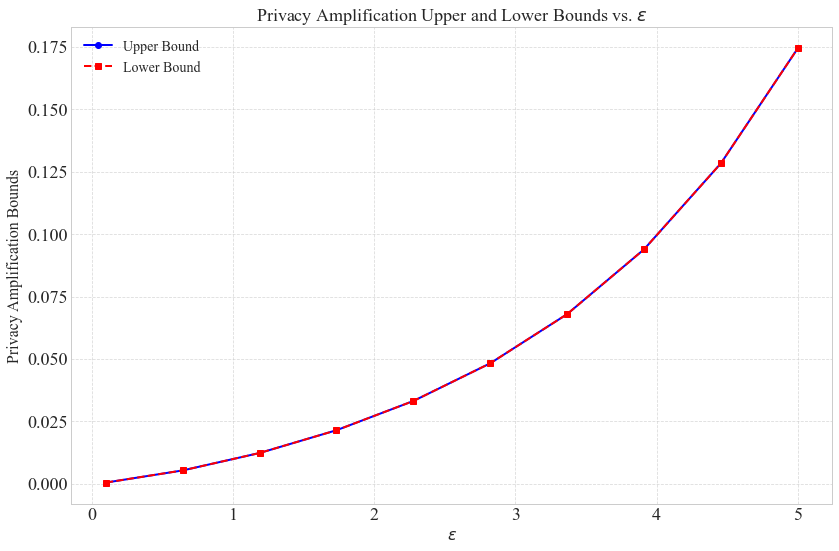

In [77]:
import scipy.stats as stats
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt

############################
# 1. 拉普拉斯 逻辑与聚合函数 #
############################

def laplace_client(value, epsilon=0.5):
    """
    给定单个用户的真实数值 value ∈ [0,1]，
    使用拉普拉斯噪声 (scale=1/epsilon) 生成扰动值并返回。
    """
    scale = 1.0 / epsilon
    noise = np.random.laplace(loc=0.0, scale=scale)
    noisy_value = value + noise
    return noisy_value

def laplace_aggregator(reported_values):
    """
    聚合方：对所有用户上报的带噪声数值取平均，
    作为对真实均值的估计。
    """
    # 使用 NaN 处理被删除的数据
    est_mean = np.nanmean(reported_values)
    return est_mean

############################
# 2. 单次实验: SDP / MPSDP #
############################

def run_one_experiment(n=10**5, epsilon=0.5, malicious_scenario='SDP',
                       malicious_ratio=0.1, drop_threshold=1.5, drop_prob=0.5,
                       seed=None):
    """
    单次实验:
      - n=10^5
      - epsilon: 隐私参数 (0.1 ~ 5)
      - malicious_scenario ∈ {'SDP', 'MPSDP'}
         => 'SDP'    恶意用户可直接上报最大值2.0 (OPA)
         => 'MPSDP'  恶意用户将输入=1.0后执行拉普拉斯扰动 (IPA)
      - malicious_ratio=0.1 => 10% 恶意用户
      - drop_threshold=1.5: 在 IPA 场景下，如果噪声后值 > 1.5，则以 drop_prob 概率删除
      - Shuffle DP放大 => epsilon_eff = epsilon + 0.5 ln(n)
    返回 (true_mean, est_mean, mse).
    """
    if seed is not None:
        np.random.seed(seed)

    # 1. 生成真实数据
    true_values = np.random.rand(n)
    true_mean = np.mean(true_values)

    # 2. Shuffle DP 放大
    epsilon_eff = epsilon + 0.5 * np.log(n)

    # 3. 选取恶意用户
    num_mal = int(malicious_ratio * n)
    malicious_indices = set(np.random.choice(n, size=num_mal, replace=False))

    # 4. 上报值
    reported_values = np.empty(n)
    reported_values[:] = np.nan  # 初始化为 NaN，方便后续处理

    # 诚实用户
    honest_indices = np.array(list(set(range(n)) - malicious_indices))
    # 向诚实用户提交带噪声的真实值
    reported_values[honest_indices] = [
        laplace_client(val, epsilon_eff) for val in true_values[honest_indices]
    ]

    # 恶意用户
    if malicious_scenario == 'SDP':
        # SDP: 恶意用户可直接上报最大值2.0 (OPA)
        reported_values[list(malicious_indices)] = 2.0
    elif malicious_scenario == 'MPSDP':
        # MPSDP: 恶意用户将输入=1.0后执行拉普拉斯扰动 (IPA)
        ipa_values = np.array([
            laplace_client(1.0, epsilon_eff) for _ in malicious_indices
        ])
        # 如果噪声后值 > drop_threshold，则以 drop_prob 概率删除
        drop_mask = ipa_values > drop_threshold
        drop_decision = np.random.rand(len(ipa_values)) < drop_prob
        ipa_values[drop_mask & drop_decision] = np.nan  # 删除
        reported_values[list(malicious_indices)] = ipa_values
    else:
        raise ValueError("malicious_scenario 必须是 'SDP' 或 'MPSDP'")

    # 5. 聚合估计
    est_mean = laplace_aggregator(reported_values)
    mse = (est_mean - true_mean) ** 2
    return true_mean, est_mean, mse

###############################
# 3. Privacy Amplification Bounds #
###############################

def Delta(ep, alpha, r0, r1, n, p, tol=1e-12):
    rate = r0 / (r0 + r1)

    def fvlow(c):
        g01 = (1 - alpha - alpha * p) * (n - (c + 1)) / (1 - r0 - r1)
        low01 = ((np.exp(ep) * p - 1) * alpha * (c + 1) / r1 + (np.exp(ep) - 1) * g01) / \
                (alpha * (p / r0 - 1 / r1 + np.exp(ep) * (p / r1 - 1 / r0)))
        g2 = (1 - alpha - alpha * p) * (n - c) / (1 - r0 - r1)
        low2 = ((np.exp(ep) * p - 1) * alpha * c / r1 + (np.exp(ep) - 1) * g2) / \
               (alpha * (p / r0 - 1 / r1 + np.exp(ep) * (p / r1 - 1 / r0)))

        v0 = np.array([1 - stats.binom.cdf(int(np.ceil(low01[i])) - 2, c[i], rate) for i in range(len(c))])
        v1 = np.array([1 - stats.binom.cdf(int(np.ceil(low01[i])) - 1, c[i], rate) for i in range(len(c))])
        v2 = np.array([1 - stats.binom.cdf(int(np.ceil(low2[i])) - 1, c[i], rate) for i in range(len(c))])

        # linear transformation (and weights are independent from c)
        p0 = p * alpha * v0 + alpha * v1 + (1 - alpha - p * alpha) * v2
        p1 = alpha * v0 + p * alpha * v1 + (1 - alpha - p * alpha) * v2
        return p0 - np.exp(ep) * p1

    def fvhigh(c):
        g01 = (1 - alpha - alpha * p) * (n - (c + 1)) / (1 - r0 - r1)
        high01 = ((np.exp(-ep) * p - 1) * alpha * (c + 1) / r1 + (np.exp(-ep) - 1) * g01) / \
                 (alpha * (p / r0 - 1 / r1 + np.exp(-ep) * (p / r1 - 1 / r0)))
        g2 = (1 - alpha - alpha * p) * (n - c) / (1 - r0 - r1)
        high2 = ((np.exp(-ep) * p - 1) * alpha * c / r1 + (np.exp(-ep) - 1) * g2) / \
                (alpha * (p / r0 - 1 / r1 + np.exp(-ep) * (p / r1 - 1 / r0)))

        v0 = np.array([stats.binom.cdf(int(np.floor(high01[i] - 1)), c[i], rate) for i in range(len(c))])
        v1 = np.array([stats.binom.cdf(int(np.floor(high01[i])), c[i], rate) for i in range(len(c))])
        v2 = np.array([stats.binom.cdf(int(np.floor(high2[i])), c[i], rate) for i in range(len(c))])

        p0 = p * alpha * v0 + alpha * v1 + (1 - alpha - p * alpha) * v2
        p1 = alpha * v0 + p * alpha * v1 + (1 - alpha - p * alpha) * v2
        return p1 - np.exp(ep) * p0

    delta0 = stats.binom.expect(fvlow, args=(n - 1, r0 + r1), lb=0, ub=n - 1, tolerance=tol, maxcount=n, chunksize=32)
    if r0 == r1:
        # by the symmetry of r0 and r1, delta0 always equals to delta1
        delta1 = delta0
    else:
        delta1 = stats.binom.expect(fvhigh, args=(n - 1, r0 + r1), lb=0, ub=n - 1, tolerance=tol, maxcount=n, chunksize=32)

    return max(delta0, delta1)

def amplificationUB(p, beta, q0, q1, n, delta, T):
    # privacy amplification upper bound
    alpha = beta / (p - 1)
    r0 = alpha * p / q0
    r1 = alpha * p / q1
    return amplificationUBCore(p, alpha, r0, r1, n, delta, T)

def amplificationUBCore(p, alpha, r0, r1, n, delta, T):
    epL = 0
    epH = np.log(p)  # one may also use the closed-form bound as a starting point

    # tolerance in scipy.stats.rv_discrete.expect
    tol = max(1e-19, min(1e-14, delta / n / 10.0))
    for t in range(T):
        ep = (epL + epH) / 2.0
        # add tol*n to delta, extremely conservative for rigidness, one may modify the scipy.stats.rv_discrete.expect to get tighter bounds
        current_delta = Delta(ep, alpha, r0, r1, n, p, tol)
        if current_delta + tol * n > delta:
            epL = ep
        else:
            epH = ep
    return epH

def amplificationLB(p, beta, q0, q1, n, delta, T):
    # privacy amplification lower bound
    alpha = beta / (p - 1)
    r0 = alpha * p / q0
    r1 = alpha * p / q1
    return amplificationLBCore(p, alpha, r0, r1, n, delta, T)

def amplificationLBCore(p, alpha, r0, r1, n, delta, T):
    epL = 0
    epH = np.log(p)

    # tolerance in scipy.stats.rv_discrete.expect
    tol = max(1e-19, min(1e-14, delta / n / 10.0))
    for t in range(T):
        ep = (epL + epH) / 2.0
        current_delta = Delta(ep, alpha, r0, r1, n, p, tol)
        # there is no tol*n, as scipy.stats.rv_discrete.expect always underestimate non-negative delta
        if current_delta > delta:
            epL = ep
        else:
            epH = ep
    return epL

def computeUBParameters(epsilon, mechanism, options=None):
    """
    根据机制和参数计算 p, beta, q0, q1。
    对于 'laplace' 机制:
        p = exp(epsilon)
        beta = (exp(epsilon) - 1) / (exp(epsilon) + 1)
        q0 = q1 = exp(epsilon)
    """
    if mechanism == 'laplace':
        p = np.exp(epsilon)
        beta = (p - 1) / (p + 1)
        q0 = q1 = p
    else:
        raise ValueError("目前只支持 'laplace' 机制")
    return p, beta, q0, q1

##############################
# 4. 主流程：计算并绘图      #
##############################

def main():
    # 配置参数
    n = 10**5
    delta = 1e-5
    T = 100  # 最大迭代次数

    # epsilon 从 0.1 到 5，取 10 个等间隔点
    epsilons = np.linspace(0.1, 5, 10)

    # 计算 p, beta, q0, q1
    p_values = np.exp(epsilons)
    beta_values = (p_values - 1) / (p_values + 1)
    q0_values = p_values
    q1_values = p_values

    # 计算上界和下界
    upper_bounds = []
    lower_bounds = []

    for i, epsilon in enumerate(epsilons):
        p = p_values[i]
        beta = beta_values[i]
        q0 = q0_values[i]
        q1 = q1_values[i]

        print(f"计算 epsilon={epsilon:.2f} 的上界和下界...")

        try:
            ub = amplificationUB(p, beta, q0, q1, n, delta, T)
            lb = amplificationLB(p, beta, q0, q1, n, delta, T)
        except Exception as e:
            print(f"计算 epsilon={epsilon:.2f} 时出错: {e}")
            ub = np.nan
            lb = np.nan

        upper_bounds.append(ub)
        lower_bounds.append(lb)

    # 绘制折线图
    plt.figure(figsize=(12, 8))
    plt.plot(epsilons, upper_bounds, label='Upper Bound', color='blue', marker='o', linestyle='-')
    plt.plot(epsilons, lower_bounds, label='Lower Bound', color='red', marker='s', linestyle='--')

    plt.xlabel('$\\varepsilon$', fontsize=18)
    plt.ylabel('\\varepsilon', fontsize=18)
#     plt.title('Privacy Amplification Upper and Lower Bounds vs. $\\varepsilon$', fontsize=18)
    plt.legend(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    # plt.yscale('log')  # 如果 bounds 变化范围较大，可以启用对数刻度
    plt.tight_layout()
    plt.savefig("privacy_amplification_bounds.pdf", dpi=300)
    plt.show()

if __name__ == "__main__":
    main()


计算机制=general，n=10000时的隐私放大上界和下界...
计算机制=general，n=20000时的隐私放大上界和下界...
计算机制=general，n=30000时的隐私放大上界和下界...
计算机制=general，n=40000时的隐私放大上界和下界...
计算机制=general，n=50000时的隐私放大上界和下界...
计算机制=general，n=60000时的隐私放大上界和下界...
计算机制=general，n=70000时的隐私放大上界和下界...
计算机制=general，n=80000时的隐私放大上界和下界...
计算机制=general，n=90000时的隐私放大上界和下界...
计算机制=general，n=100000时的隐私放大上界和下界...
计算机制=laplace，n=10000时的隐私放大上界和下界...
计算机制=laplace，n=20000时的隐私放大上界和下界...
计算机制=laplace，n=30000时的隐私放大上界和下界...
计算机制=laplace，n=40000时的隐私放大上界和下界...
计算机制=laplace，n=50000时的隐私放大上界和下界...
计算机制=laplace，n=60000时的隐私放大上界和下界...
计算机制=laplace，n=70000时的隐私放大上界和下界...
计算机制=laplace，n=80000时的隐私放大上界和下界...
计算机制=laplace，n=90000时的隐私放大上界和下界...
计算机制=laplace，n=100000时的隐私放大上界和下界...
计算机制=grr，n=10000时的隐私放大上界和下界...
计算机制=grr，n=20000时的隐私放大上界和下界...
计算机制=grr，n=30000时的隐私放大上界和下界...
计算机制=grr，n=40000时的隐私放大上界和下界...
计算机制=grr，n=50000时的隐私放大上界和下界...
计算机制=grr，n=60000时的隐私放大上界和下界...
计算机制=grr，n=70000时的隐私放大上界和下界...
计算机制=grr，n=80000时的隐私放大上界和下界...
计算机制=grr，n=90000时的隐私放大上界和下界...
计算机制=grr，n=100000时的

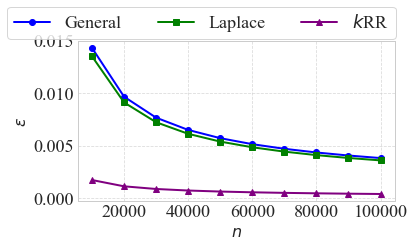

In [101]:
import scipy.stats as stats
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt

############################
# 1. Privacy Amplification Bounds Functions #
############################

def Delta(ep, alpha, r0, r1, n, p, tol=1e-12):
    rate = r0 / (r0 + r1)

    def fvlow(c):
        g01 = (1 - alpha - alpha * p) * (n - (c + 1)) / (1 - r0 - r1)
        denominator = alpha * (p / r0 - 1 / r1 + np.exp(ep) * (p / r1 - 1 / r0))
        low01 = ((np.exp(ep) * p - 1) * alpha * (c + 1) / r1 + (np.exp(ep) - 1) * g01) / denominator
        g2 = (1 - alpha - alpha * p) * (n - c) / (1 - r0 - r1)
        low2 = ((np.exp(ep) * p - 1) * alpha * c / r1 + (np.exp(ep) - 1) * g2) / denominator

        v0 = np.array([1 - stats.binom.cdf(int(np.ceil(low01_i)) - 2, c_i, rate) for low01_i, c_i in zip(low01, c)])
        v1 = np.array([1 - stats.binom.cdf(int(np.ceil(low01_i)) - 1, c_i, rate) for low01_i, c_i in zip(low01, c)])
        v2 = np.array([1 - stats.binom.cdf(int(np.ceil(low2_i)) - 1, c_i, rate) for low2_i, c_i in zip(low2, c)])

        # linear transformation (and weights are independent from c)
        p0 = p * alpha * v0 + alpha * v1 + (1 - alpha - p * alpha) * v2
        p1 = alpha * v0 + p * alpha * v1 + (1 - alpha - p * alpha) * v2
        return p0 - np.exp(ep) * p1

    def fvhigh(c):
        g01 = (1 - alpha - alpha * p) * (n - (c + 1)) / (1 - r0 - r1)
        denominator = alpha * (p / r0 - 1 / r1 + np.exp(-ep) * (p / r1 - 1 / r0))
        high01 = ((np.exp(-ep) * p - 1) * alpha * (c + 1) / r1 + (np.exp(-ep) - 1) * g01) / denominator
        g2 = (1 - alpha - alpha * p) * (n - c) / (1 - r0 - r1)
        high2 = ((np.exp(-ep) * p - 1) * alpha * c / r1 + (np.exp(-ep) - 1) * g2) / denominator

        v0 = np.array([stats.binom.cdf(int(np.floor(high01_i - 1)), c_i, rate) for high01_i, c_i in zip(high01, c)])
        v1 = np.array([stats.binom.cdf(int(np.floor(high01_i)), c_i, rate) for high01_i, c_i in zip(high01, c)])
        v2 = np.array([stats.binom.cdf(int(np.floor(high2_i)), c_i, rate) for high2_i, c_i in zip(high2, c)])

        # linear transformation (and weights are independent from c)
        p0 = p * alpha * v0 + alpha * v1 + (1 - alpha - p * alpha) * v2
        p1 = alpha * v0 + p * alpha * v1 + (1 - alpha - p * alpha) * v2
        return p1 - np.exp(ep) * p0

    delta0 = stats.binom.expect(fvlow, args=(n - 1, r0 + r1), lb=0, ub=n - 1, tolerance=tol, maxcount=n, chunksize=32)
    if r0 == r1:
        # by the symmetry of r0 and r1, delta0 always equals to delta1
        delta1 = delta0
    else:
        delta1 = stats.binom.expect(fvhigh, args=(n - 1, r0 + r1), lb=0, ub=n - 1, tolerance=tol, maxcount=n, chunksize=32)

    return max(delta0, delta1)

def amplificationUB(p, beta, q0, q1, n, delta, T):
    # privacy amplification upper bound
    alpha = beta / (p - 1)
    r0 = alpha * p / q0
    r1 = alpha * p / q1
    return amplificationUBCore(p, alpha, r0, r1, n, delta, T)

def amplificationUBCore(p, alpha, r0, r1, n, delta, T):
    epL = 0
    epH = np.log(p)  # one may also use the closed-form bound as a starting point

    # tolerance in scipy.stats.rv_discrete.expect
    tol = max(1e-19, min(1e-14, delta / n / 10.0))
    for t in range(T):
        ep = (epL + epH) / 2.0
        # add tol*n to delta, extremely conservative for rigidness, one may modify the scipy.stats.rv_discrete.expect to get tighter bounds
        current_delta = Delta(ep, alpha, r0, r1, n, p, tol)
        if current_delta + tol * n > delta:
            epL = ep
        else:
            epH = ep
    return epH

def amplificationLB(p, beta, q0, q1, n, delta, T):
    # privacy amplification lower bound
    alpha = beta / (p - 1)
    r0 = alpha * p / q0
    r1 = alpha * p / q1
    return amplificationLBCore(p, alpha, r0, r1, n, delta, T)

def amplificationLBCore(p, alpha, r0, r1, n, delta, T):
    epL = 0
    epH = np.log(p)

    # tolerance in scipy.stats.rv_discrete.expect
    tol = max(1e-19, min(1e-14, delta / n / 10.0))
    for t in range(T):
        ep = (epL + epH) / 2.0
        current_delta = Delta(ep, alpha, r0, r1, n, p, tol)
        # there is no tol*n, as scipy.stats.rv_discrete.expect always underestimate non-negative delta
        if current_delta > delta:
            epL = ep
        else:
            epH = ep
    return epL

def computeUBParameters(epsilon, mechanism, d=100, options=None):
    """
    根据机制和参数计算 p, beta, q0, q1。
    支持 'general', 'laplace', 'grr' 三种机制。
    """
    p = np.exp(epsilon)
    q0 = q1 = p

    if mechanism == 'general':
        beta = (p - 1) / (p + 1)
    elif mechanism == 'laplace':
        beta = 1 - np.exp(-epsilon / 2)
    elif mechanism == 'grr':
        beta = (p - 1) / (p + d - 1)
    else:
        raise ValueError("机制类型必须是 'general', 'laplace' 或 'grr'")
    
    return p, beta, q0, q1

##############################
# 2. 主流程：计算并绘图      #
##############################

def main():
    plt.style.use('seaborn-whitegrid')
    matplotlib.rcParams['font.family'] = 'Times New Roman'  # 设置字体为 Times New Roman
    matplotlib.rcParams['font.size'] = 18
    matplotlib.rcParams['axes.labelsize'] = 15
    matplotlib.rcParams['axes.titlesize'] = 18
    matplotlib.rcParams['legend.fontsize'] = 18
    matplotlib.rcParams['lines.linewidth'] = 2
    # 配置参数
    epsilon = 0.5  # 固定epsilon
    mechanisms = ['general', 'laplace', 'grr']
    d = 100  # GRR机制中的d值
    n_values = np.linspace(1e4, 1e5, 10).astype(int)  # n从10^4到10^5，共10个点
    delta = 1e-5
    T = 100  # 最大迭代次数

    # 初始化字典存储结果
    results_upper = {mech: [] for mech in mechanisms}
    results_lower = {mech: [] for mech in mechanisms}

    # 计算每个机制在不同n下的上界和下界
    for mech in mechanisms:
        for n in n_values:
            print(f"计算机制={mech}，n={n}时的隐私放大上界和下界...")
            try:
                p, beta, q0, q1 = computeUBParameters(epsilon, mech, d=d)
                ub = amplificationUB(p, beta, q0, q1, n, delta, T)
#                 lb = amplificationLB(p, beta, q0, q1, n, delta, T)
            except Exception as e:
                print(f"计算机制={mech}，n={n}时出错: {e}")
                ub = np.nan
#                 lb = np.nan
            results_upper[mech].append(ub)
#             results_lower[mech].append(lb)

    # 绘制折线图
    plt.figure(figsize=(6, 4))

    # 定义颜色和标记
    colors = {
        'general': 'blue',
        'laplace': 'green',
        'grr': 'purple'
    }
    markers = {
        'general': 'o',
        'laplace': 's',
        'grr': '^'
    }

    for mech in mechanisms:
        if mech=='grr':
            plt.plot(n_values, results_upper[mech], label='$k$RR',
                 color=colors[mech], marker=markers[mech], linestyle='-')
        else:   
            plt.plot(n_values, results_upper[mech], label=f'{mech.capitalize()}',
                 color=colors[mech], marker=markers[mech], linestyle='-')
#         plt.plot(n_values, results_lower[mech], label=f'{mech.capitalize()} Lower Bound',
#                  color=colors[mech], marker=markers[mech], linestyle='--')

    plt.xlabel('$n$', fontsize=16)
    plt.ylabel('$\\varepsilon$', fontsize=16)
#     plt.title('Privacy Amplification Upper and Lower Bounds vs. Number of Users (n)', fontsize=18)

    # 图例放在顶部居中    
    plt.legend(
        loc='lower center',
        bbox_to_anchor=(0.39, 1.01),
        ncol=3,  # 两个标签并排
        borderaxespad=0,
        frameon=True
    )

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 留出顶部空间给图例

    plt.savefig("privacy_amplification_bounds_vs_n.pdf", dpi=300)
    plt.show()

if __name__ == "__main__":
    main()


In [100]:
import scipy.stats as stats
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt

############################
# 1. Privacy Amplification Bounds Functions #
############################

def Delta(ep, alpha, r0, r1, n, p, tol=1e-12):
    rate = r0 / (r0 + r1)

    def fvlow(c):
        g01 = (1 - alpha - alpha * p) * (n - (c + 1)) / (1 - r0 - r1)
        denominator = alpha * (p / r0 - 1 / r1 + np.exp(ep) * (p / r1 - 1 / r0))
        low01 = ((np.exp(ep) * p - 1) * alpha * (c + 1) / r1 + (np.exp(ep) - 1) * g01) / denominator
        g2 = (1 - alpha - alpha * p) * (n - c) / (1 - r0 - r1)
        low2 = ((np.exp(ep) * p - 1) * alpha * c / r1 + (np.exp(ep) - 1) * g2) / denominator

        v0 = np.array([1 - stats.binom.cdf(int(np.ceil(low01_i)) - 2, c_i, rate) for low01_i, c_i in zip(low01, c)])
        v1 = np.array([1 - stats.binom.cdf(int(np.ceil(low01_i)) - 1, c_i, rate) for low01_i, c_i in zip(low01, c)])
        v2 = np.array([1 - stats.binom.cdf(int(np.ceil(low2_i)) - 1, c_i, rate) for low2_i, c_i in zip(low2, c)])

        # linear transformation (and weights are independent from c)
        p0 = p * alpha * v0 + alpha * v1 + (1 - alpha - p * alpha) * v2
        p1 = alpha * v0 + p * alpha * v1 + (1 - alpha - p * alpha) * v2
        return p0 - np.exp(ep) * p1

    def fvhigh(c):
        g01 = (1 - alpha - alpha * p) * (n - (c + 1)) / (1 - r0 - r1)
        denominator = alpha * (p / r0 - 1 / r1 + np.exp(-ep) * (p / r1 - 1 / r0))
        high01 = ((np.exp(-ep) * p - 1) * alpha * (c + 1) / r1 + (np.exp(-ep) - 1) * g01) / denominator
        g2 = (1 - alpha - alpha * p) * (n - c) / (1 - r0 - r1)
        high2 = ((np.exp(-ep) * p - 1) * alpha * c / r1 + (np.exp(-ep) - 1) * g2) / denominator

        v0 = np.array([stats.binom.cdf(int(np.floor(high01_i - 1)), c_i, rate) for high01_i, c_i in zip(high01, c)])
        v1 = np.array([stats.binom.cdf(int(np.floor(high01_i)), c_i, rate) for high01_i, c_i in zip(high01, c)])
        v2 = np.array([stats.binom.cdf(int(np.floor(high2_i)), c_i, rate) for high2_i, c_i in zip(high2, c)])

        # linear transformation (and weights are independent from c)
        p0 = p * alpha * v0 + alpha * v1 + (1 - alpha - p * alpha) * v2
        p1 = alpha * v0 + p * alpha * v1 + (1 - alpha - p * alpha) * v2
        return p1 - np.exp(ep) * p0

    delta0 = stats.binom.expect(fvlow, args=(n - 1, r0 + r1), lb=0, ub=n - 1, tolerance=tol, maxcount=n, chunksize=32)
    if r0 == r1:
        # by the symmetry of r0 and r1, delta0 always equals to delta1
        delta1 = delta0
    else:
        delta1 = stats.binom.expect(fvhigh, args=(n - 1, r0 + r1), lb=0, ub=n - 1, tolerance=tol, maxcount=n, chunksize=32)

    return max(delta0, delta1)

def amplificationUB(p, beta, q0, q1, n, delta, T):
    # Privacy Amplification Upper Bound
    alpha = beta / (p - 1)
    r0 = alpha * p / q0
    r1 = alpha * p / q1
    return amplificationUBCore(p, alpha, r0, r1, n, delta, T)

def amplificationUBCore(p, alpha, r0, r1, n, delta, T):
    epL = 0
    epH = np.log(p)  # Initial upper bound

    # Tolerance for the expectation computation
    tol = max(1e-19, min(1e-14, delta / n / 10.0))
    for t in range(T):
        ep = (epL + epH) / 2.0
        # Compute current delta
        current_delta = Delta(ep, alpha, r0, r1, n, p, tol)
        if current_delta + tol * n > delta:
            epL = ep
        else:
            epH = ep
    return epH

def amplificationLB(p, beta, q0, q1, n, delta, T):
    # Privacy Amplification Lower Bound
    alpha = beta / (p - 1)
    r0 = alpha * p / q0
    r1 = alpha * p / q1
    return amplificationLBCore(p, alpha, r0, r1, n, delta, T)

def amplificationLBCore(p, alpha, r0, r1, n, delta, T):
    epL = 0
    epH = np.log(p)

    # Tolerance for the expectation computation
    tol = max(1e-19, min(1e-14, delta / n / 10.0))
    for t in range(T):
        ep = (epL + epH) / 2.0
        current_delta = Delta(ep, alpha, r0, r1, n, p, tol)
        if current_delta > delta:
            epL = ep
        else:
            epH = ep
    return epL

def computeUBParameters(epsilon, mechanism, d=100, options=None):
    """
    根据机制和参数计算 p, beta, q0, q1。
    支持 'general', 'laplace', 'grr' 三种机制。
    """
    p = np.exp(epsilon)
    q0 = q1 = p

    if mechanism == 'general':
        beta = (p - 1) / (p + 1)
    elif mechanism == 'laplace':
        beta = 1 - np.exp(-epsilon / 2)
    elif mechanism == 'grr':
        beta = (p - 1) / (p + d - 1)
    else:
        raise ValueError("机制类型必须是 'general', 'laplace' 或 'grr'")
    
    return p, beta, q0, q1

##############################
# 2. 主流程：计算并绘图      #
##############################

def main():
    plt.style.use('seaborn-whitegrid')
    matplotlib.rcParams['font.family'] = 'Times New Roman'  # 设置字体为 Times New Roman
    matplotlib.rcParams['font.size'] = 18
    matplotlib.rcParams['axes.labelsize'] = 15
    matplotlib.rcParams['axes.titlesize'] = 18
    matplotlib.rcParams['legend.fontsize'] = 18
    matplotlib.rcParams['lines.linewidth'] = 2
    # 配置参数
    n = 10**5
    delta = 1e-5
    T = 10  # 最大迭代次数

    # epsilon 从 0.1 到 5，取 10 个等间隔点
    epsilons = np.linspace(0.1, 5, 10)

    # 定义机制
    mechanisms = ['general', 'laplace', 'grr']
    d = 100  # GRR机制中的d值

    # 初始化字典存储结果
    results_upper = {mech: [] for mech in mechanisms}
    results_lower = {mech: [] for mech in mechanisms}

    # 计算每个机制在不同epsilon下的上界和下界
    for mech in mechanisms:
        for epsilon in epsilons:
            print(f"计算机制={mech}，epsilon={epsilon:.2f}时的隐私放大上界和下界...")
            try:
                p, beta, q0, q1 = computeUBParameters(epsilon, mech, d=d)
                ub = amplificationUB(p, beta, q0, q1, n, delta, T)
#                 lb = amplificationLB(p, beta, q0, q1, n, delta, T)
            except Exception as e:
                print(f"计算机制={mech}，epsilon={epsilon:.2f}时出错: {e}")
                ub = np.nan
                lb = np.nan
            results_upper[mech].append(ub)
#             results_lower[mech].append(lb)

    # 绘制折线图
    plt.figure(figsize=(6, 4))

    # 定义颜色和标记
    colors = {
        'general': 'blue',
        'laplace': 'green',
        'grr': 'purple'
    }
    linestyles = {
        'upper': '-',
        'lower': '--'
    }
    markers = {
        'general': 'o',
        'laplace': 's',
        'grr': '^'
    }

    for mech in mechanisms:
        if mech=='grr':
            plt.plot(epsilons, results_upper[mech], label='$k$RR',
                 color=colors[mech], marker=markers[mech], linestyle=linestyles['upper'])
        else:   
            plt.plot(epsilons, results_upper[mech], label=f'{mech.capitalize()}',
                 color=colors[mech], marker=markers[mech], linestyle=linestyles['upper'])
#         plt.plot(epsilons, results_lower[mech], label=f'{mech.capitalize()} Lower Bound',
#                  color=colors[mech], marker=markers[mech], linestyle=linestyles['lower'])

    plt.xlabel('$\\varepsilon$', fontsize=14)
    plt.ylabel('$\\varepsilon\'$)', fontsize=14)
#     plt.title('Privacy Amplification Upper and Lower Bounds vs. $\\varepsilon$', fontsize=18)

    # 图例放在顶部居中
    plt.legend(
        loc='lower center',
        bbox_to_anchor=(0.38, 1.01),
        ncol=3,  # 两个标签并排
        borderaxespad=0,
        frameon=True
    )

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 留出顶部空间给图例

    plt.savefig("privacy_amplification_bounds_vs_epsilon.pdf", dpi=300)
    plt.show()

if __name__ == "__main__":
    main()


计算机制=general，epsilon=0.10时的隐私放大上界和下界...
计算机制=general，epsilon=0.64时的隐私放大上界和下界...
计算机制=general，epsilon=1.19时的隐私放大上界和下界...
计算机制=general，epsilon=1.73时的隐私放大上界和下界...


KeyboardInterrupt: 